#ML4Net - Lab 3

## Team members

Javi (266933) | Marta (267436) | Arnau (216530)

## Description

In this lab, you will train a time series forecaster using Federated Learning (FL).

The dataset you are going to use contains data from multiple APs. In particular, each AP's dataset contains the following features:

* `datetime` is the timestamp (date) at which the measurement was taken
* `Bytes` is the number of Bytes contributed at the corresponding datetime
* `Active Connections` is the number of active connections (users connected to the AP) at the corresponding datetime
* `Active Users` is the number of active users at the corresponding datetime
* `AP ID` is the ID of the AP where the measurement was taken

Original dataset: Chen, W., Lyu, F., Wu, F., Yang, P., & Ren, J. (2021). Flag: Flexible, accurate, and long-time user load prediction in large-scale WiFi system using deep RNN. IEEE Internet of Things Journal, 8(22), 16510-16521.

## Instructions

*   Follow the steps from this Notebook and complete the proposed exercises.
*   Deliver the completed Notebook by uploading it to your Github repository.
*   **Submission deadline: 8 June 2025 (EoB).**

## Setting up the environment

1. Connect your Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Download the dataset

In [2]:
# !wget https://github.com/fwilhelmi/fwilhelmi.github.io/blob/master/files/datasetLab3.pkl

3. Define the main path of the code

In [3]:
mypath="drive/Shareddrives/AAX/Lab3"

4. Extract the source code to the destination folder

In [4]:
!mkdir $mypath;
#!cp datasetLab3.pkl $mypath; cd $mypath;
%cd $mypath


mkdir: cannot create directory ‘drive/Shareddrives/AAX/Lab3’: File exists
/content/drive/Shareddrives/AAX/Lab3


In [5]:
pwd

'/content/drive/Shareddrives/AAX/Lab3'

## Loading the data




Load the data from the pickle file (https://docs.python.org/3/library/pickle.html) that contains the dataset.

**Important:** If you have issues with the dataset after automatically downloading and extracting it, download it and move it manually to the indicated folder.

In [6]:
import pickle
import os
#os.chdir(mypath)

print(os.getcwd())
print(os.path.exists('datasetLab3.pkl'))

# Open and load the pickle file
try:
    with open('datasetLab3.pkl', 'rb') as f:
        loaded_data = pickle.load(f)
    print("Data loaded successfully:")
    print(loaded_data)
except FileNotFoundError:
    print("Error: 'datasetLab3.pkl' not found.")
except Exception as e:
    print(f"An error occurred: {e}")

/content/drive/Shareddrives/AAX/Lab3
True
Data loaded successfully:
                     Bytes  Active Connections  Active Users   AP ID
datetime                                                            
2019-04-30 07:10:00    0.0            0.075209           0.0  7-1012
2019-04-30 07:20:00    0.0            0.000000           0.0  7-1012
2019-04-30 07:30:00    0.0            0.000000           0.0  7-1012
2019-04-30 07:40:00    0.0            0.000000           0.0  7-1012
2019-04-30 07:50:00    0.0            0.000000           0.0  7-1012
...                    ...                 ...           ...     ...
2019-05-14 07:10:00    0.0            0.000000           0.0   7-104
2019-05-14 07:20:00    0.0            0.000000           0.0   7-104
2019-05-14 07:30:00    0.0            0.000000           0.0   7-104
2019-05-14 07:40:00    0.0            0.000000           0.0   7-104
2019-05-14 07:50:00    0.0            0.034091           0.0   7-104

[211064 rows x 4 columns]


## EXERCISES

### **Imports**

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import defaultdict

### **Analysis of the dataset**

Previous to the exercises, we want to understand the dataset that we will work with.

For that purpose, we first compute the mean and sumation of every feature for each different AP ID. With this computation we can compute a top N AP IDs for each category and aggregation so we can visually inspect which APs seem to be interesting for our study.

In [8]:
# Groupping by AP ID, we compute the mean and sumation of each feature
agg_values = loaded_data.groupby('AP ID')[['Bytes', 'Active Connections', 'Active Users']].agg(['mean', 'sum'])

agg_values.columns = ['_'.join(col) for col in agg_values.columns]
agg_values.reset_index(inplace=True)

for feature in ['Bytes', 'Active Connections', 'Active Users']:

    print("-"*40)
    print(f"Top 5 by average {feature}:")
    print(agg_values.sort_values(by=f"{feature}_mean", ascending=False)[['AP ID', f"{feature}_mean"]].head(5))
    print("-"*40)

    print(f"Top 5 by sum {feature}:")
    print(agg_values.sort_values(by=f"{feature}_sum", ascending=False)[['AP ID', f"{feature}_sum"]].head(5))
    print("-"*40)



----------------------------------------
Top 5 by average Bytes:
     AP ID     Bytes_mean
44  7-1057  578626.555555
21  7-1026  256028.089015
36  7-1048  160233.110638
45  7-1058  158426.929420
82  7-1114  147470.284473
----------------------------------------
Top 5 by sum Bytes:
     AP ID     Bytes_sum
44  7-1057  1.366137e+09
21  7-1026  5.537888e+08
45  7-1058  3.510741e+08
82  7-1114  3.474400e+08
36  7-1048  3.393737e+08
----------------------------------------
----------------------------------------
Top 5 by average Active Connections:
     AP ID  Active Connections_mean
36  7-1048                 7.650575
44  7-1057                 7.215531
92  7-1130                 5.507651
82  7-1114                 5.185898
81  7-1113                 4.944471
----------------------------------------
Top 5 by sum Active Connections:
     AP ID  Active Connections_sum
44  7-1057            17035.868333
36  7-1048            16203.918333
92  7-1130            12342.645000
82  7-1114         

From the obtained tops, we conclude:

* Access Points 7-1057 and 7-1048 seem like the busiest access points overall (metrics and features).


* Access point 7-1026 transmits the top-2 amount of Bytes but does not have many active users or connections.


* Access points 7-1114 and 7-1130 have a large amount of active connections and users but do not transmit as many Bytes


* Access point 7-1058 has a notable amount of active users but not active connections nor bytes transmitted.


Therefore, we decided that we will study the following APs, as we consider their behaviour might vary significantly:


* **7-1057**: Overall, most busy / most contributing
* **7-1026**: One of the most contributing without high active connections
* **7-1130**: One of the busiest without high contribution
* **7-1058**: One of the busiest according to active users but deficient in the other features.




We then inspect the timestamps for each selected AP, in order to see the range of their measurements.

In [9]:
n_aps = loaded_data['AP ID'].nunique()

selected_aps = ["7-1057", "7-1026", "7-1130", "7-1058"]
ap_grouped = loaded_data.groupby('AP ID')

for AP_ID, AP_df in ap_grouped:
  if AP_ID in selected_aps:
    print("-"*20)
    print(f"Observing timesteps for AP{AP_ID}")
    datetimes = AP_df.index
    even = True
    for i in range(len(datetimes)-1):
      cur_diff = datetimes[i+1] - datetimes[i]
      if i != 0:
        if (cur_diff).seconds != prev_diff.seconds:
          even = False
          print("-"*40)
          print(f"Uneven timestep of {cur_diff} versus {prev_diff} seconds at AP{AP_ID}")
          print("-"*40)
      prev_diff = cur_diff
    if even:
      print(f"AP{AP_ID} has equally spaced timesteps")
      print(f"Timestep of {cur_diff.seconds} seconds observed for AP{AP_ID}")
    print(f"AP{AP_ID} starts measuring at {datetimes.min()} and finishes at {datetimes.max()}")
    print("-"*20)



--------------------
Observing timesteps for AP7-1026
AP7-1026 has equally spaced timesteps
Timestep of 600 seconds observed for AP7-1026
AP7-1026 starts measuring at 2019-04-29 22:40:00 and finishes at 2019-05-14 23:00:00
--------------------
--------------------
Observing timesteps for AP7-1057
AP7-1057 has equally spaced timesteps
Timestep of 600 seconds observed for AP7-1057
AP7-1057 starts measuring at 2019-04-28 12:50:00 and finishes at 2019-05-14 22:10:00
--------------------
--------------------
Observing timesteps for AP7-1058
AP7-1058 has equally spaced timesteps
Timestep of 600 seconds observed for AP7-1058
AP7-1058 starts measuring at 2019-04-29 08:50:00 and finishes at 2019-05-14 18:00:00
--------------------
--------------------
Observing timesteps for AP7-1130
AP7-1130 has equally spaced timesteps
Timestep of 600 seconds observed for AP7-1130
AP7-1130 starts measuring at 2019-04-29 10:10:00 and finishes at 2019-05-14 23:30:00
--------------------


We can see that observed APs have the same range of days, although one AP starts taking measurements late in the day (7-1026). All time steps are of 600 seconds, equivalently, 10 minutes.

Now, we plot the average per hour, weekday, and month of each feature for the selected APs.

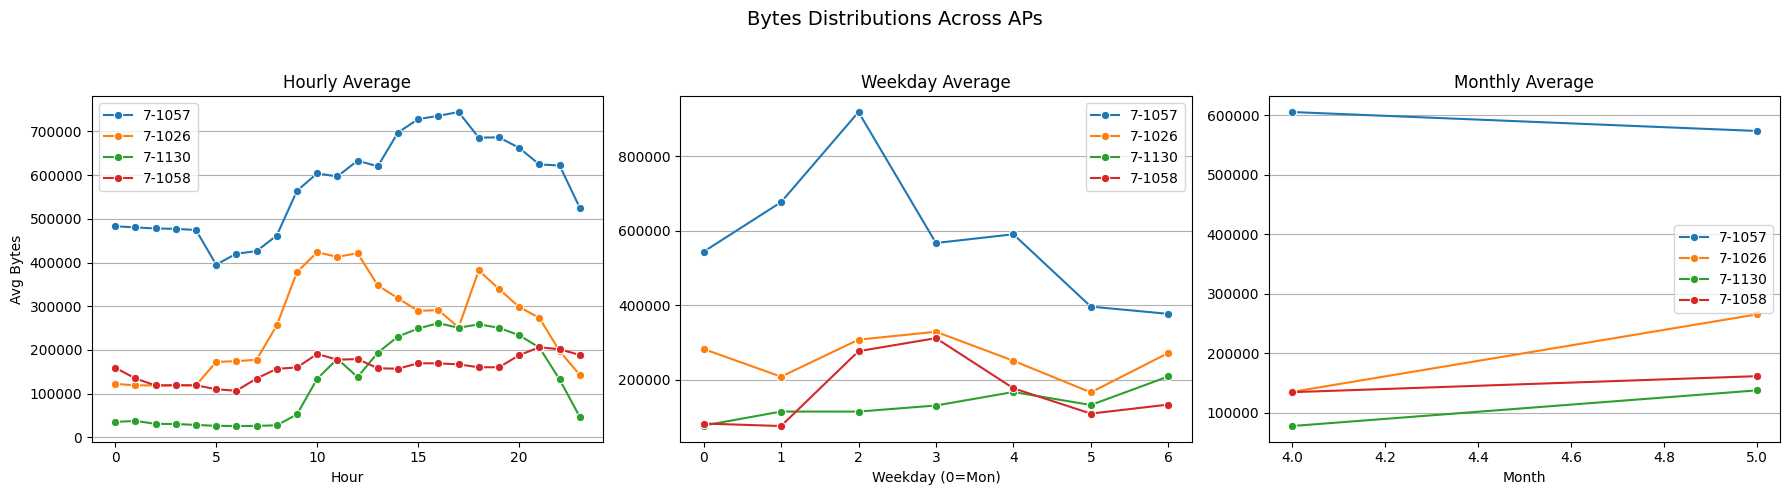

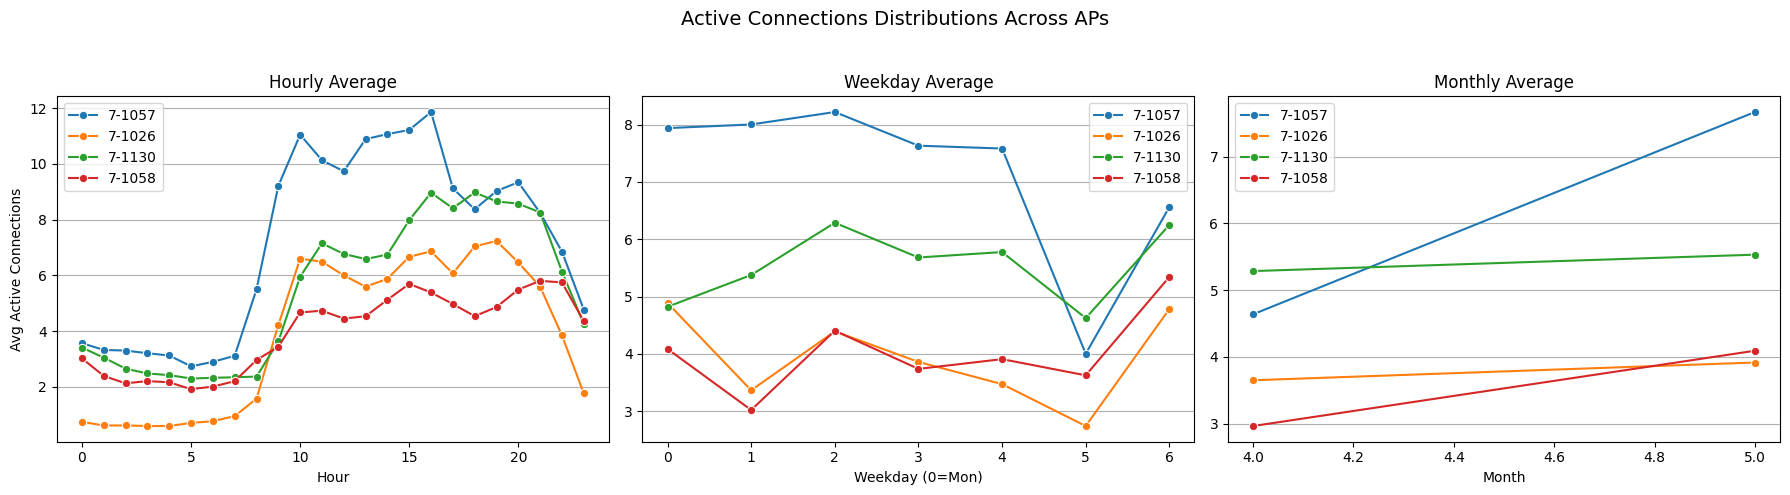

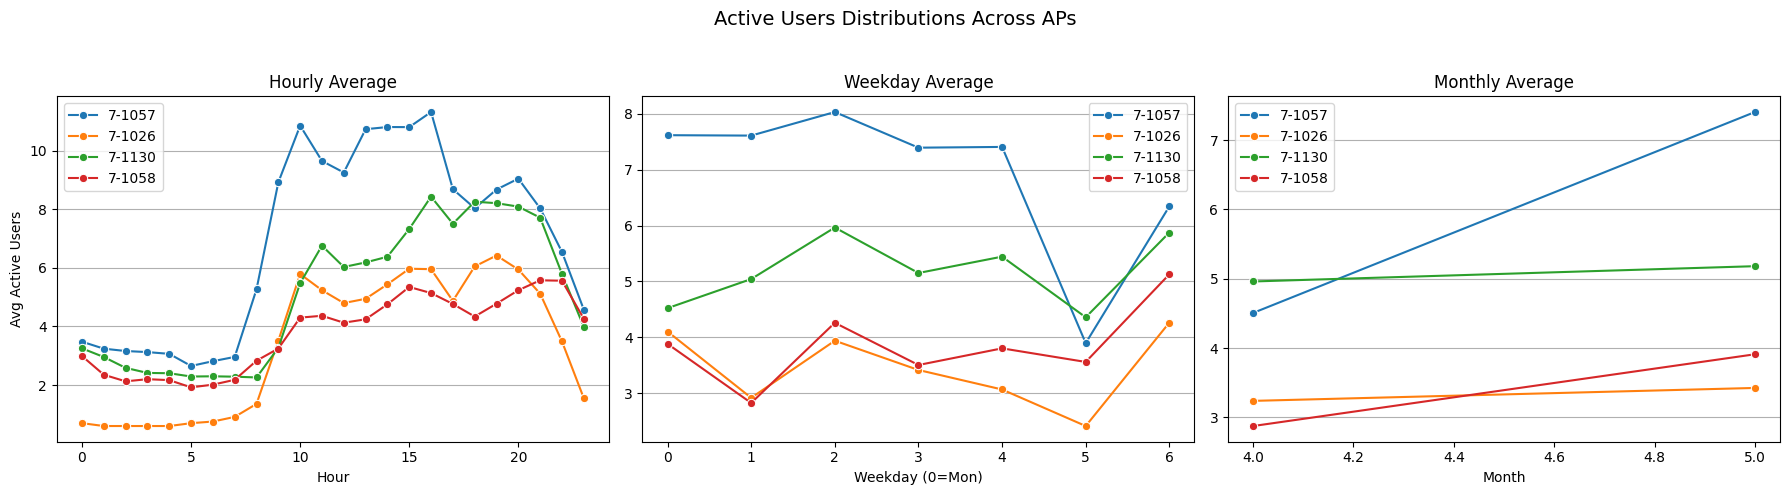

In [10]:
# Features and selected APs
features = ["Bytes", "Active Connections", "Active Users"]
selected_aps = ["7-1057", "7-1026", "7-1130", "7-1058"]

# Filter dataset
filtered_df = loaded_data[loaded_data["AP ID"].isin(selected_aps)].copy()

# Add time-based columns
filtered_df["hour"] = filtered_df.index.hour
filtered_df["weekday"] = filtered_df.index.weekday
filtered_df["month"] = filtered_df.index.month

# Plot one set of 3 plots (hour, weekday, month) per feature
for feature in features:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{feature} Distributions Across APs", fontsize=14)

    # Hourly plot
    for ap in selected_aps:
        ap_df = filtered_df[filtered_df["AP ID"] == ap]
        hourly_avg = ap_df.groupby("hour")[feature].mean().reset_index()
        sns.lineplot(ax=axes[0], x="hour", y=feature, data=hourly_avg, label=ap, marker='o')
    axes[0].set_title("Hourly Average")
    axes[0].set_xlabel("Hour")
    axes[0].set_ylabel(f"Avg {feature}")
    axes[0].legend()
    axes[0].grid(axis='y')

    # Weekday plot
    for ap in selected_aps:
        ap_df = filtered_df[filtered_df["AP ID"] == ap]
        weekday_avg = ap_df.groupby("weekday")[feature].mean().reset_index()
        sns.lineplot(ax=axes[1], x="weekday", y=feature, data=weekday_avg, label=ap, marker='o')
    axes[1].set_title("Weekday Average")
    axes[1].set_xlabel("Weekday (0=Mon)")
    axes[1].set_ylabel("")
    axes[1].legend()
    axes[1].grid(axis='y')

    # Monthly plot
    for ap in selected_aps:
        ap_df = filtered_df[filtered_df["AP ID"] == ap]
        monthly_avg = ap_df.groupby("month")[feature].mean().reset_index()
        sns.lineplot(ax=axes[2], x="month", y=feature, data=monthly_avg, label=ap, marker='o')
    axes[2].set_title("Monthly Average")
    axes[2].set_xlabel("Month")
    axes[2].set_ylabel("")
    axes[2].legend()
    axes[2].grid(axis='y')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


By looking at the plots, we can see how Active Users and Active Connections features share a similar behavior for all APs, additionally both features follow similar trends. The trends of the previous features might seem similar to the trends shown by feature Bytes, but the later exhibits anomalous behavior with respect to the previous. We will try and explain this later on this section.

The three features have a spike during the working hours, and tend to be lower before and after.

As for the weekdays, we can see how the weekend is when there are fewer bytes transmitted, being Saturday the day with the least Active Connections and Active Users. Nonetheless, we observe how these two features show an increase on Sunday. Again, we will try to explain this later on the section.

Next, we can plot bar graphs of the data to have a better look at how the features compare between APs for each hour/weekday/month slot.

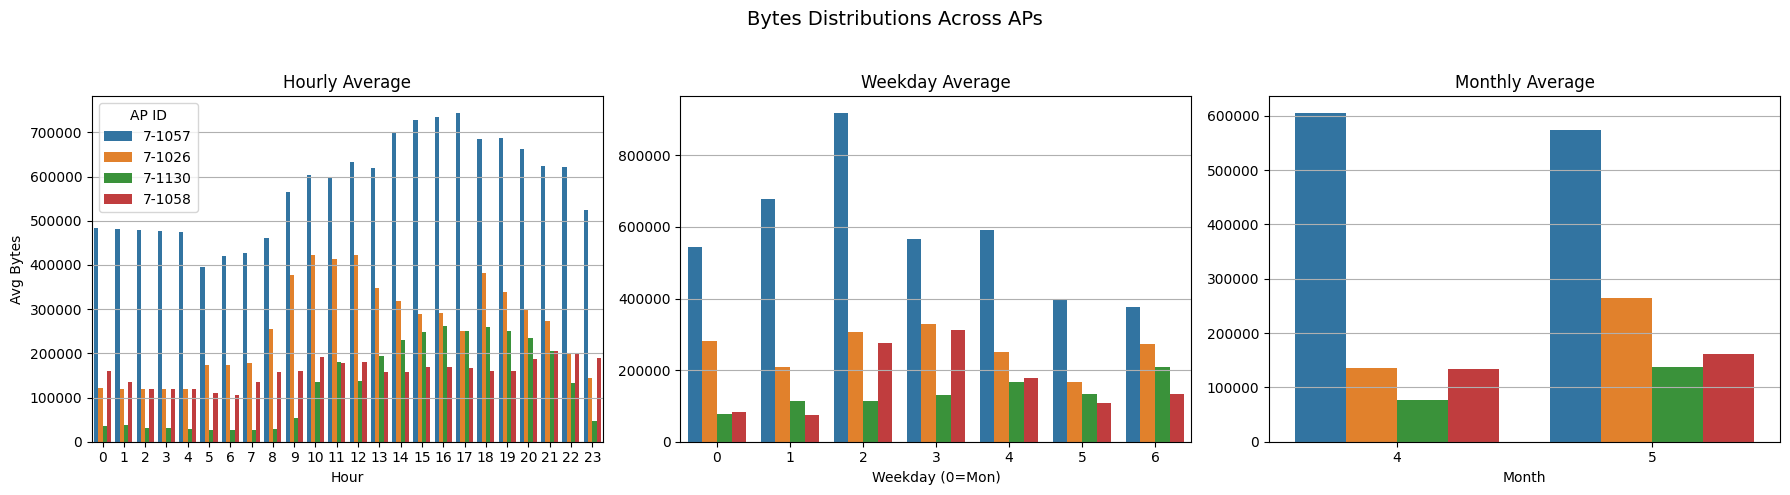

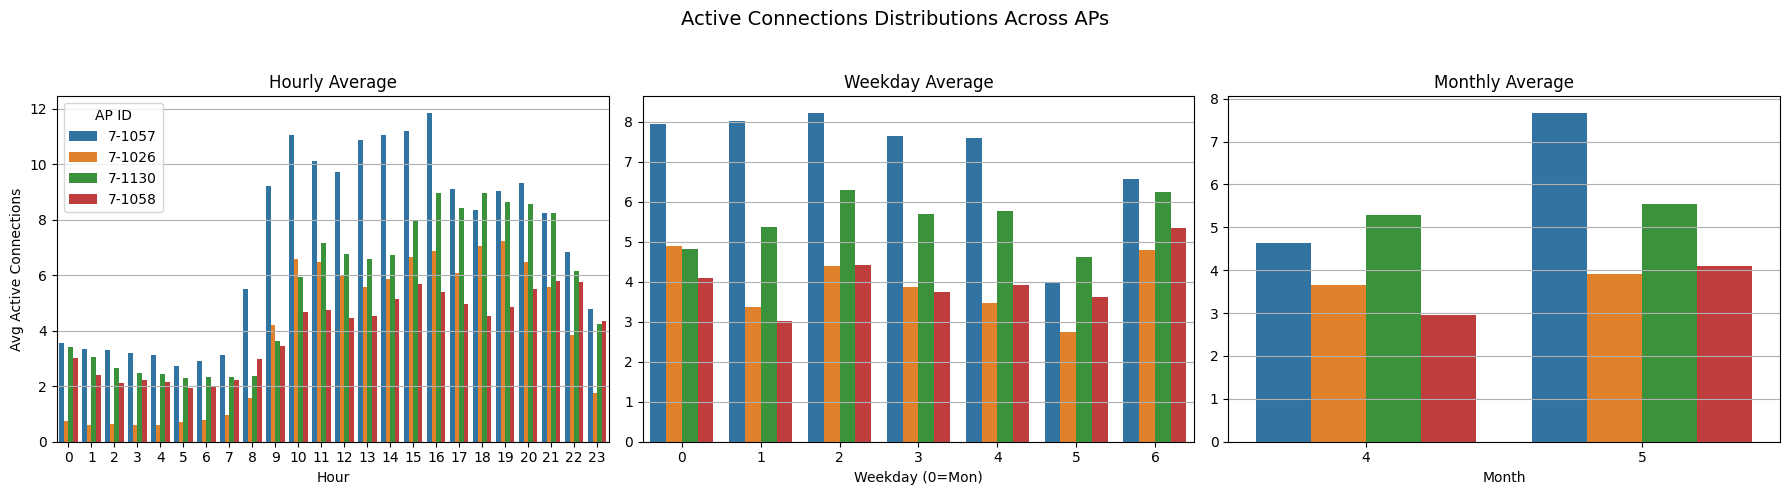

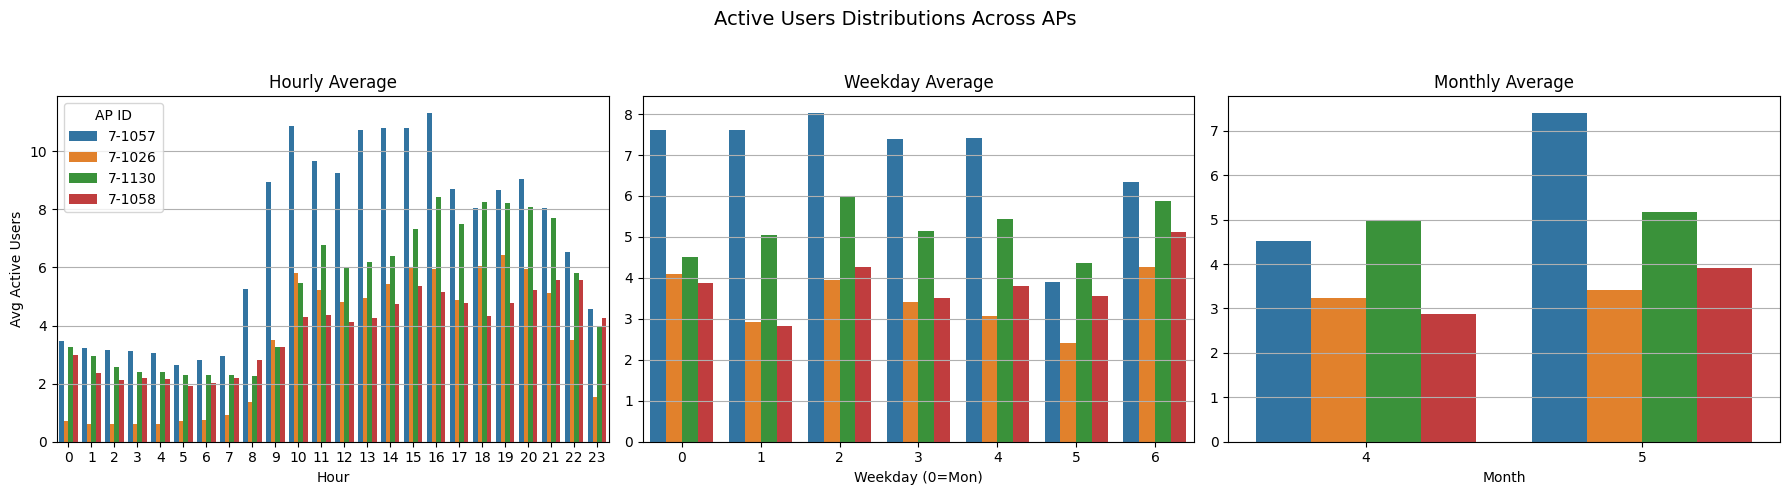

In [11]:
# Features and APs
features = ["Bytes", "Active Connections", "Active Users"]
selected_aps = ["7-1057", "7-1026", "7-1130", "7-1058"]

# Filter dataset and add time columns
filtered_df = loaded_data[loaded_data["AP ID"].isin(selected_aps)].copy()
filtered_df["hour"] = filtered_df.index.hour
filtered_df["weekday"] = filtered_df.index.weekday
filtered_df["month"] = filtered_df.index.month

# Plotting loop
for feature in features:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{feature} Distributions Across APs", fontsize=14)

    # --- Hourly ---
    hourly_avg = (
        filtered_df.groupby(["AP ID", "hour"])[feature]
        .mean()
        .reset_index()
    )
    hourly_avg['AP ID'] = pd.Categorical(hourly_avg['AP ID'], categories=selected_aps, ordered=True)
    hourly_avg.sort_values('AP ID', inplace=True)

    sns.barplot(ax=axes[0], data=hourly_avg, x="hour", y=feature, hue="AP ID")
    axes[0].set_title("Hourly Average")
    axes[0].set_xlabel("Hour")
    axes[0].set_ylabel(f"Avg {feature}")
    axes[0].grid(axis='y')

    # --- Weekday ---
    weekday_avg = (
        filtered_df.groupby(["AP ID", "weekday"])[feature]
        .mean()
        .reset_index()
    )
    weekday_avg['AP ID'] = pd.Categorical(weekday_avg['AP ID'], categories=selected_aps, ordered=True)
    weekday_avg.sort_values('AP ID', inplace=True)

    sns.barplot(ax=axes[1], data=weekday_avg, x="weekday", y=feature, hue="AP ID")
    axes[1].set_title("Weekday Average")
    axes[1].set_xlabel("Weekday (0=Mon)")
    axes[1].set_ylabel("")
    axes[1].grid(axis='y')

    # --- Monthly ---
    monthly_avg = (
        filtered_df.groupby(["AP ID", "month"])[feature]
        .mean()
        .reset_index()
    )
    monthly_avg['AP ID'] = pd.Categorical(monthly_avg['AP ID'], categories=selected_aps, ordered=True)
    monthly_avg.sort_values('AP ID', inplace=True)

    sns.barplot(ax=axes[2], data=monthly_avg, x="month", y=feature, hue="AP ID")
    axes[2].set_title("Monthly Average")
    axes[2].set_xlabel("Month")
    axes[2].set_ylabel("")
    axes[2].grid(axis='y')

    # Final layout
    order = [1,0,3,2]
    axes[0].legend(title="AP ID")
    axes[1].legend().set_visible(False)
    axes[2].legend().set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


From both these and the previous plots, it is easy to see that he AP 7-1057 (blue) is the one with the biggest values amongst the four in every feature and metric, but specially in bytes transmitted. 7-1026 (orange), 7-1058 (yellow), and 7-1130 (green) behave quite similarly, with 7-1130 often being in the lead.

We have noticed that the dataset ranges from 28-04-2019 to 15-05-2019.
This is meaningful as the dates comprise the Labour day, celebrated in China as part of the Golden Week festivities. These festivities will likely alter the behavior of all the APs in the dataset, meaning we will have festive days in between the regular week of 29-04-2019 to 05-05-2019. Additionally, we notice that the Sundays 28-04-2019 and 05-05-2019 were working days in spite of being a Sunday. This fact most probably explains the unusual number of Active Connections and Active Users on Sundays previously seen.

The full calendar of Chinese festivities can be consulted [here](https://www.timeanddate.com/holidays/china/2019).

Inspecting the calendar we realize that Saturdays were the only truly festive day across all weeks present in the dataset, explaining the dip in every feature on Saturdays.

We see that our dataset is divided in two halves. A half corresponding to the Golden Week, and the other to a regular week. This might explain how the second month (May) mostly sees an increase in Active Connections and Active Users, as it comprises a longer period, and part of that period is composed of regular weeks, meaning more activity on the campus.



To confirm our suspicions we will see the plots separated by weeks, starting with the Golden Week.

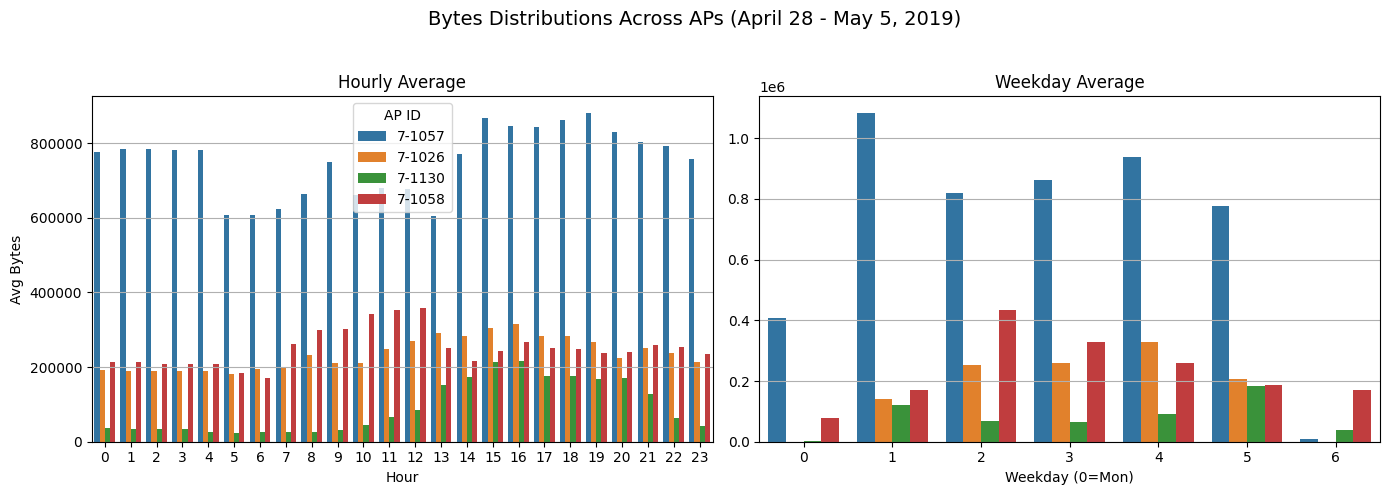

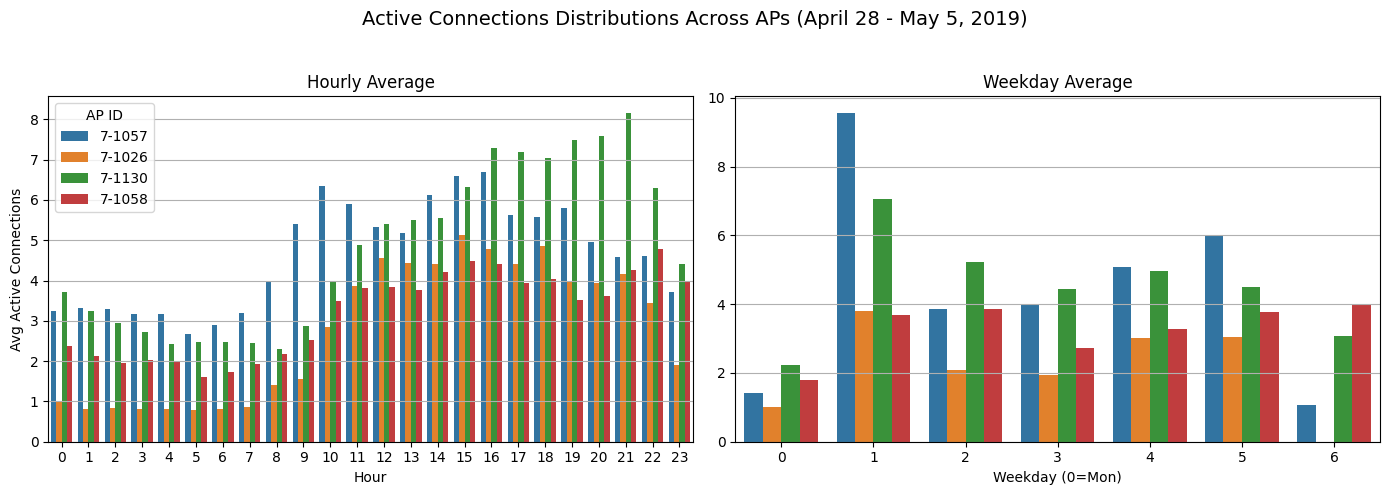

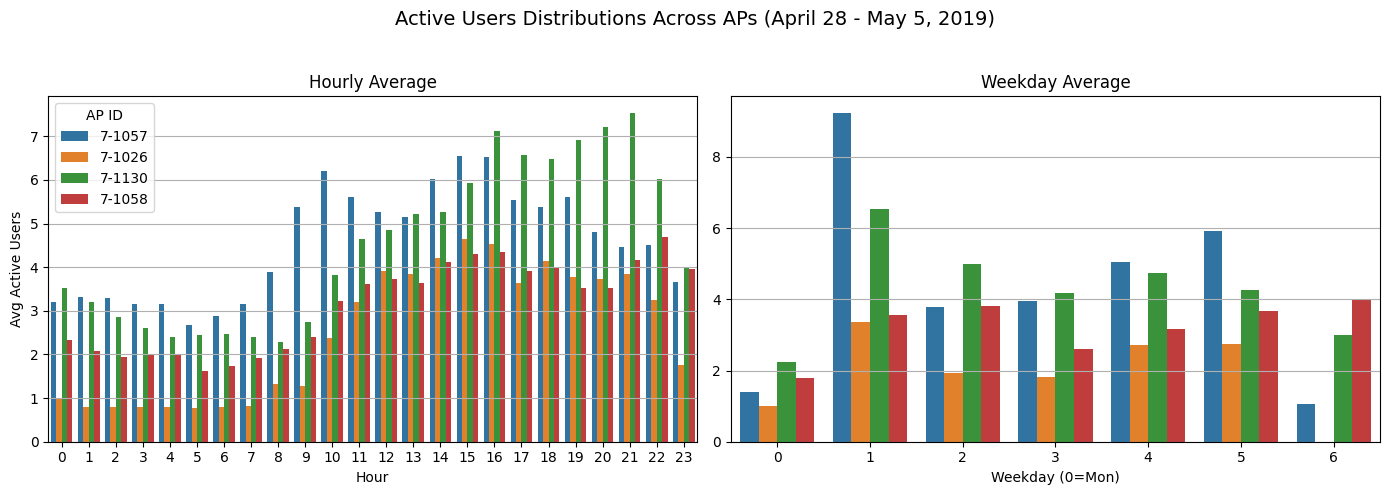

In [12]:
# Filter dataset by datetime index and AP IDs
filtered_df = loaded_data.loc[
    (loaded_data.index <= "2019-05-05") &
    (loaded_data["AP ID"].isin(selected_aps))
].copy()

# Add time columns
filtered_df["hour"] = filtered_df.index.hour
filtered_df["weekday"] = filtered_df.index.weekday

features = ["Bytes", "Active Connections", "Active Users"]

# Plot grouped barplots for filtered data
for feature in features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"{feature} Distributions Across APs (April 28 - May 5, 2019)", fontsize=14)

    # Hourly
    hourly_avg = filtered_df.groupby(["AP ID", "hour"])[feature].mean().reset_index()
    hourly_avg['AP ID'] = pd.Categorical(hourly_avg['AP ID'], categories=selected_aps, ordered=True)
    hourly_avg.sort_values('AP ID', inplace=True)

    sns.barplot(ax=axes[0], data=hourly_avg, x="hour", y=feature, hue="AP ID")
    axes[0].set_title("Hourly Average")
    axes[0].set_xlabel("Hour")
    axes[0].set_ylabel(f"Avg {feature}")
    axes[0].grid(axis='y')

    # Weekday
    weekday_avg = filtered_df.groupby(["AP ID", "weekday"])[feature].mean().reset_index()
    weekday_avg['AP ID'] = pd.Categorical(weekday_avg['AP ID'], categories=selected_aps, ordered=True)
    weekday_avg.sort_values('AP ID', inplace=True)

    sns.barplot(ax=axes[1], data=weekday_avg, x="weekday", y=feature, hue="AP ID")
    axes[1].set_title("Weekday Average")
    axes[1].set_xlabel("Weekday (0=Mon)")
    axes[1].set_ylabel("")
    axes[1].grid(axis='y')

    axes[0].legend(title="AP ID")
    axes[1].legend().set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


From previous plot, we can see how the behavior of some APs varies due to the festivities.

At first glance, we can see how some APs do not have activity in some features.
AP 7-1026 does not have Active Users, Active Connections, nor Bytes contributed on Sundays, meaning this AP was unused on Sundays. This could imply that the AP was probably an AP located in the library or some section of classrooms, anywhere that was not frequented by both students and workers simultaneously.

We can observe how APs 7-1026 and 7-1130 do not have Bytes contributed on Monday, which is suposed to be a workday, meaning these APs might be located in some place that will be frequented during the festivities only. Perhaps some sort of meeting room or conference room dedicated to the celebration.

To confirm these new suspicions, we will look at the next week, allegedly a regular work week.

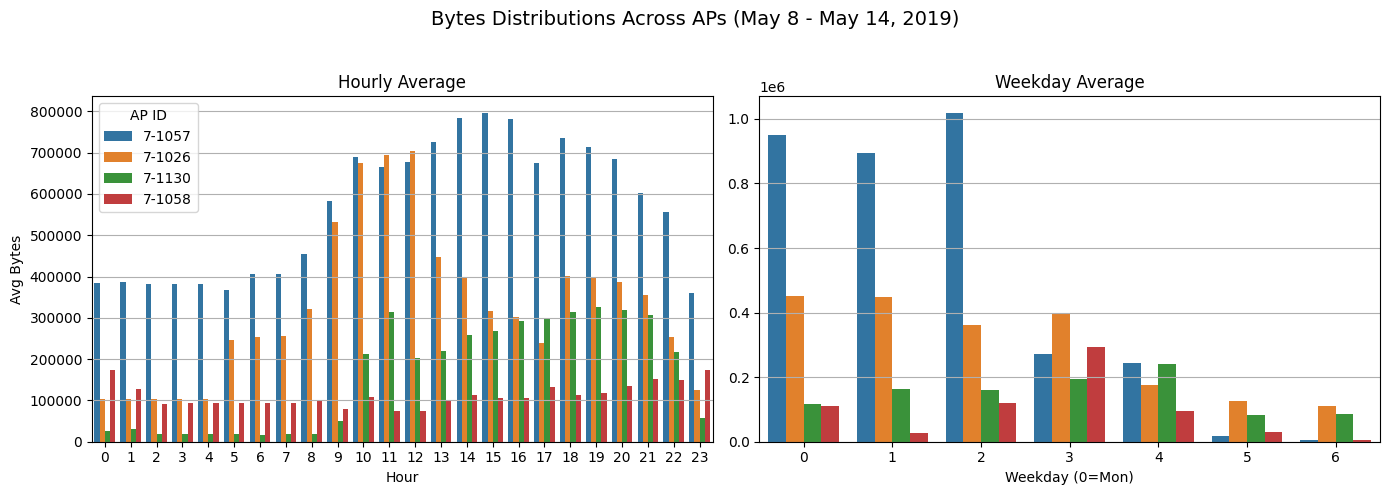

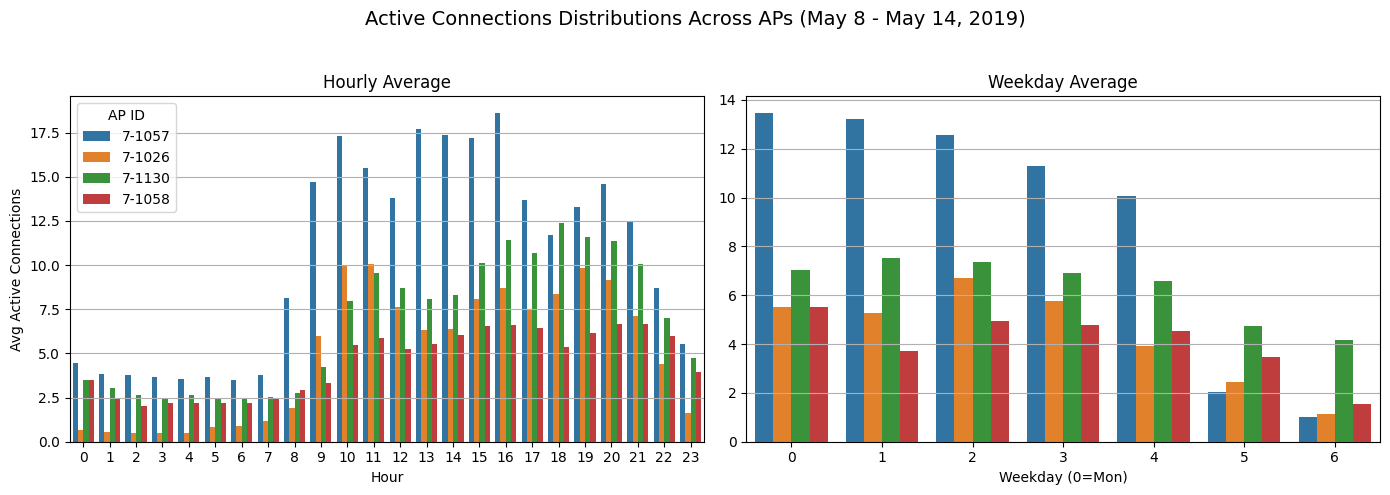

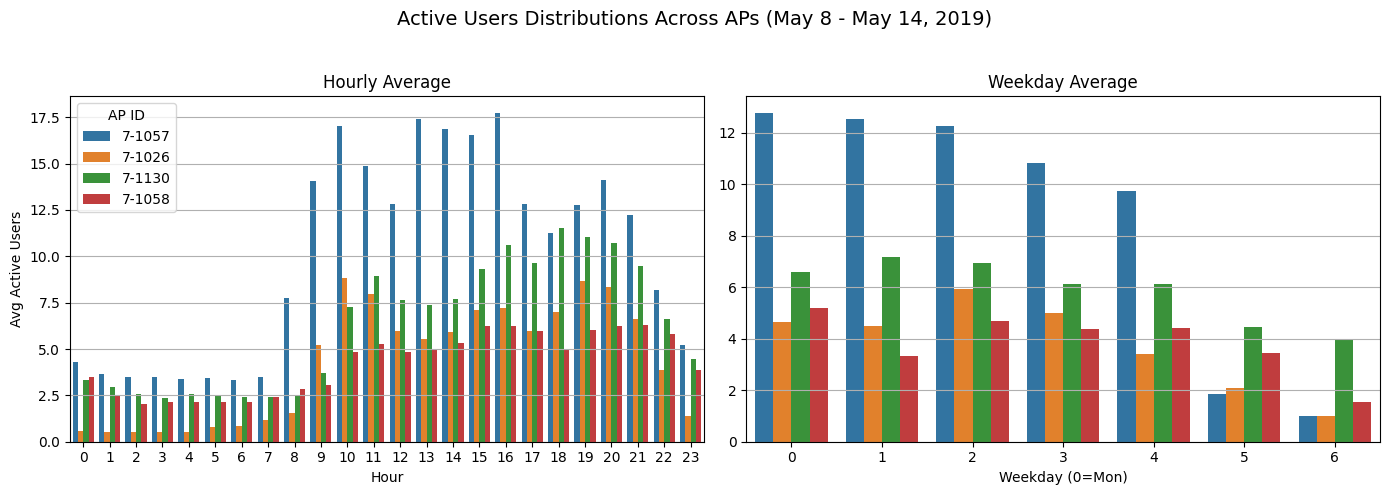

In [13]:
# Filter dataset by datetime index and AP IDs for May 8 to May 14, 2019
filtered_df = loaded_data.loc[
    (loaded_data.index >= "2019-05-06") &
    (loaded_data.index <= "2019-05-12") &
    (loaded_data["AP ID"].isin(selected_aps))
].copy()

# Add time columns
filtered_df["hour"] = filtered_df.index.hour
filtered_df["weekday"] = filtered_df.index.weekday

features = ["Bytes", "Active Connections", "Active Users"]

# Plot grouped barplots for filtered data
for feature in features:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(f"{feature} Distributions Across APs (May 8 - May 14, 2019)", fontsize=14)

    # Hourly
    hourly_avg = filtered_df.groupby(["AP ID", "hour"])[feature].mean().reset_index()
    hourly_avg['AP ID'] = pd.Categorical(hourly_avg['AP ID'], categories=selected_aps, ordered=True)
    hourly_avg.sort_values('AP ID', inplace=True)

    sns.barplot(ax=axes[0], data=hourly_avg, x="hour", y=feature, hue="AP ID")
    axes[0].set_title("Hourly Average")
    axes[0].set_xlabel("Hour")
    axes[0].set_ylabel(f"Avg {feature}")
    axes[0].grid(axis='y')

    # Weekday
    weekday_avg = filtered_df.groupby(["AP ID", "weekday"])[feature].mean().reset_index()
    weekday_avg['AP ID'] = pd.Categorical(weekday_avg['AP ID'], categories=selected_aps, ordered=True)
    weekday_avg.sort_values('AP ID', inplace=True)

    sns.barplot(ax=axes[1], data=weekday_avg, x="weekday", y=feature, hue="AP ID")
    axes[1].set_title("Weekday Average")
    axes[1].set_xlabel("Weekday (0=Mon)")
    axes[1].set_ylabel("")
    axes[1].grid(axis='y')

    axes[0].legend(title="AP ID")
    axes[1].legend().set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


These plots show how the festivities in China affect the data gathered.

Now we can see how the weekend days have what would be normal activity for each feature and AP.

We can notice how, although being in the middle range of values for every feature AP 7-1130 maintains the same activity in each feature along the week, this could mean that the AP is located in some place such that connections are continuosly happening, be it a concurred place, or some sort of dorm rooms. Another suspicion, could be that this is near a server room of sorts.


During this week, lots of tourists visit China and Chinese citizens tend to travel and stay with the family, so this spike in the first day may be due to flights, train schedules, GPS navigation, etc. Overall, more bytes are transmitted during the first week, as it is a regular working week.

Now,to have some numbers to help us visualize previous conclusions, let's see the mean of all features together per week.

In [14]:
# Define the two weeks as date ranges
week1_start, week1_end = "2019-04-28", "2019-05-05"
week2_start, week2_end = "2019-05-06", "2019-05-12"

# Filter data for the two weeks
week1_data = loaded_data.loc[
    (loaded_data.index >= week1_start) & (loaded_data.index <= week1_end)
]
week2_data = loaded_data.loc[
    (loaded_data.index >= week2_start) & (loaded_data.index <= week2_end)
]

# Features to compare
features = ["Bytes", "Active Connections", "Active Users"]

# Compute mean of each feature across all APs for each week
week1_means = week1_data[features].mean()
week2_means = week2_data[features].mean()

# Combine results into a DataFrame for easy comparison
comparison_df = pd.DataFrame({
    "Golden Week (April 28 - May 5)": week1_means,
    "Next Week (May 6 - May 12)": week2_means
})

print(comparison_df)


                    Golden Week (April 28 - May 5)  Next Week (May 6 - May 12)
Bytes                                 36320.177260                45614.031529
Active Connections                        1.064466                    2.145646
Active Users                              0.831895                    1.622899


As seen from the graphs and deduced from our observations, there are fewer Bytes transmitted, along with fewer Active Connections and Active Users, during the Golden Week.

This means that we will have significantly varying behaviors per AP, and across weeks for all APs. This will then influence how the dataset needs to be handled, and will play an important role on exercise 6.

To understand better the effect of these festivities, we will see the averages of each feature per weekday on the Golden week period.

In [15]:
# Filter festive week data and create a copy to avoid SettingWithCopyWarning
festive_week_data = loaded_data.loc[
    (loaded_data.index >= "2019-04-28") & (loaded_data.index <= "2019-05-05")
].copy()

# Now safely add the 'date' column
festive_week_data['date'] = festive_week_data.index.date

# Features to calculate daily averages for
features = ["Bytes", "Active Connections", "Active Users"]

# Group by date and calculate mean for each feature
daily_averages = festive_week_data.groupby('date')[features].mean()

print(daily_averages)

                   Bytes  Active Connections  Active Users
date                                                      
2019-04-28  28600.444585            1.000000      1.000000
2019-04-29  80310.748957            1.378175      1.373506
2019-04-30  55637.381567            2.330882      1.770910
2019-05-01  29134.880283            0.788193      0.603556
2019-05-02  26590.127852            0.667611      0.518533
2019-05-03  35179.999616            0.739302      0.583659
2019-05-04  32151.440049            0.927111      0.734279
2019-05-05  11735.803927            0.550657      0.441919


We see that the first Sunday (28-04) has somewhat high number of Active Connections and Active Users, due to it being an exceptional workday.

Then we observe that 29-04 and 30-04 being regular workdays have what we suppose its the regular activity of a workday in the campus.

We can see how the Labour day (01-05) marks the start of the dip due to festivities in all categories.

But, something unusual happens on the weekend (04-05 and 05-05). Saturday has a somewhat high number of Active Connections and Active Users, perhaps due to some celebration in the campus. And Sunday has an unexpectedly low value for all features in spite of it being an exceptional workday.

We will then, compare this activity to the regular week activity.

In [16]:
# Filter next week data and create a copy to avoid warnings
next_week_data = loaded_data.loc[
    (loaded_data.index >= "2019-05-06") & (loaded_data.index <= "2019-05-12")
].copy()

# Add 'date' column safely
next_week_data['date'] = next_week_data.index.date

# Features to calculate daily averages for
features = ["Bytes", "Active Connections", "Active Users"]

# Group by date and calculate mean for each feature
next_week_daily_averages = next_week_data.groupby('date')[features].mean()

print(next_week_daily_averages)


                   Bytes  Active Connections  Active Users
date                                                      
2019-05-06  60813.109247            2.620880      2.002545
2019-05-07  52891.859900            2.470935      1.865423
2019-05-08  63086.647446            2.750463      2.091498
2019-05-09  39741.804379            2.137790      1.562700
2019-05-10  43022.934566            2.120174      1.656795
2019-05-11  14398.846952            0.785801      0.567482
2019-05-12   6588.113721            0.393822      0.319747


As expected workdays have a wildly superior number of Bytes contributed, Active Connections and Active Users than the weekend. This means that the campus has retaken normal activity.

The numbers align with what we have seen in the last round of graphs.

### **Exercise 1:**
***
Analyze the data from the different APs and discuss their properites (stationarity, trends, seasonality).

Select 2 or 3 key APs showing different properties and generate:

* Line plots (to plot the load vs the time)
* Autocorrelation plots (to show the relationship between past and future samples of the load)
* An Augmented Dickey-Fuller test (to study the stationarity of the AP)

***



#### **Line Plots**

For this exercise, we will first see the Line plots representing the load of Bytes contributed of each AP against time, being time the timestamps during which the AP was taking measurements.

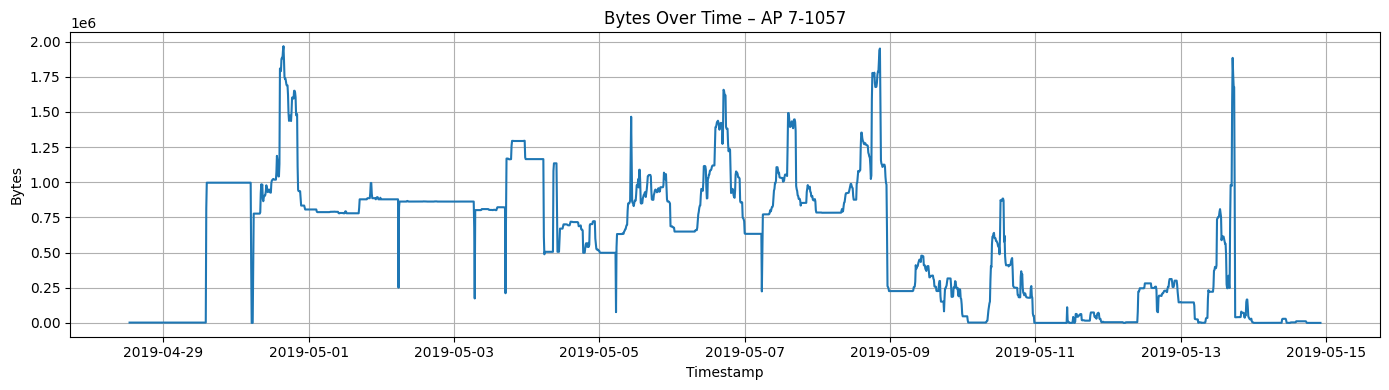

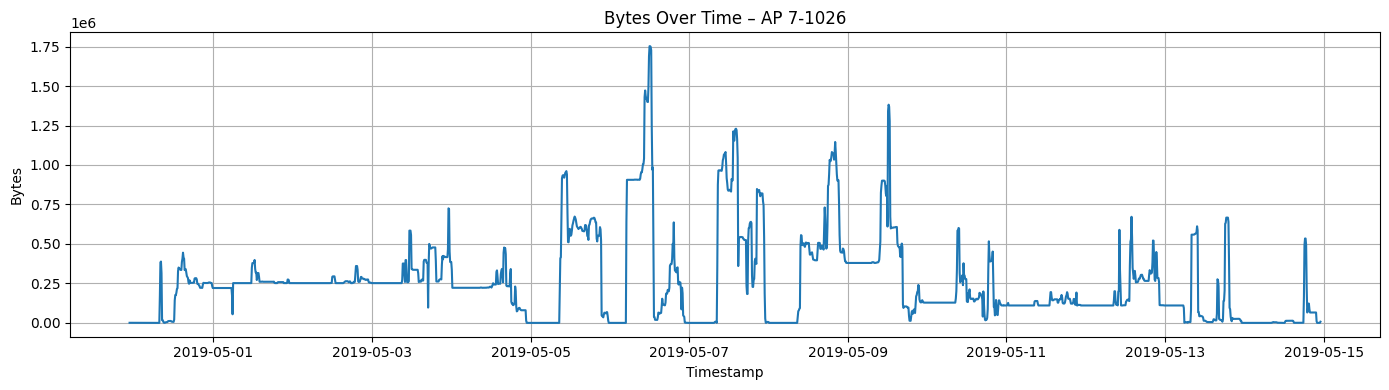

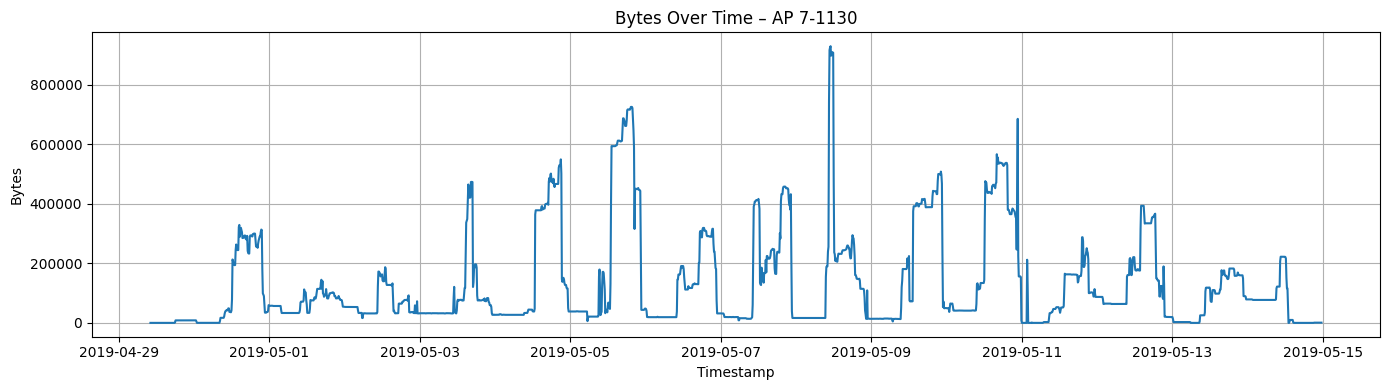

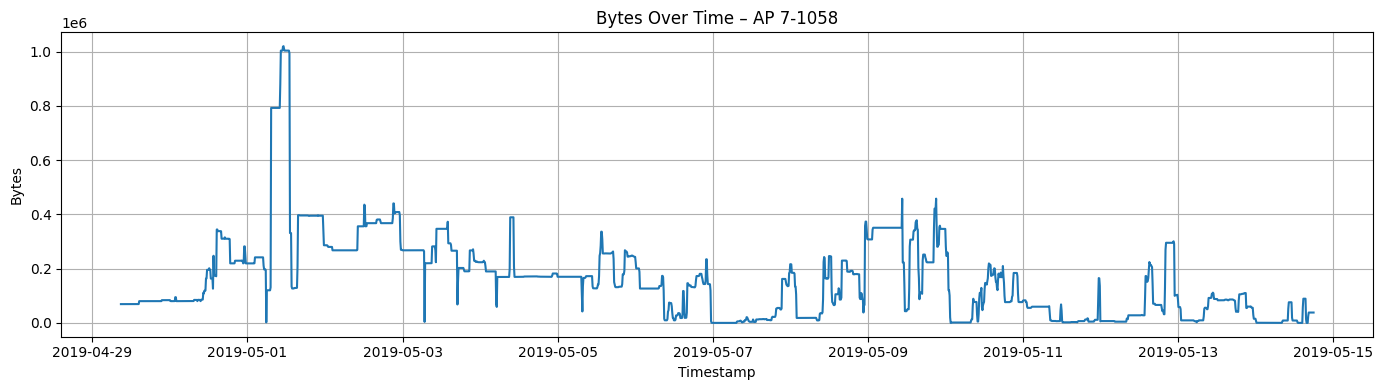

In [17]:
import matplotlib.pyplot as plt

# Filter data for selected APs
selected_df = loaded_data[loaded_data["AP ID"].isin(selected_aps)].copy()

# Plot Bytes vs Time for each AP separately
for ap_id in selected_aps:
    ap_data = selected_df[selected_df["AP ID"] == ap_id]

    plt.figure(figsize=(14, 4))
    plt.plot(ap_data.index, ap_data["Bytes"], label=f"AP {ap_id}")
    plt.title(f"Bytes Over Time – AP {ap_id}")
    plt.xlabel("Timestamp")
    plt.ylabel("Bytes")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


We have explained in detail the bytes transmitted; the plot is similar to what we have seen before.

We can see that AP 7-1058 and 7-1057 present higher contribution during the Golden Week than the other APs.

We can see how AP 7-1130 contributes significantly less Bytes than the others across all measurements.

We can see the previously mentioned small shift in starting and ending times for measurements of the 4 APs.

#### **Autocorrelation Plots**

Now, we will continue by showing autocorrelation plots for each of our APs, for the Bytes feature. It's important to note that the lag corresponds to a timedelta of 10 minutes per unit of lag. This means that we have the following conversions:

* 6 lags = 60 minutes = 1 hour

* 144 lags = 24 hours = 1 day

* 1008 lags = 7 days = 1 week

These conversions will help us conduct an analysis on the behavior and predictability of the Bytes feature for each AP.

<Figure size 1200x400 with 0 Axes>

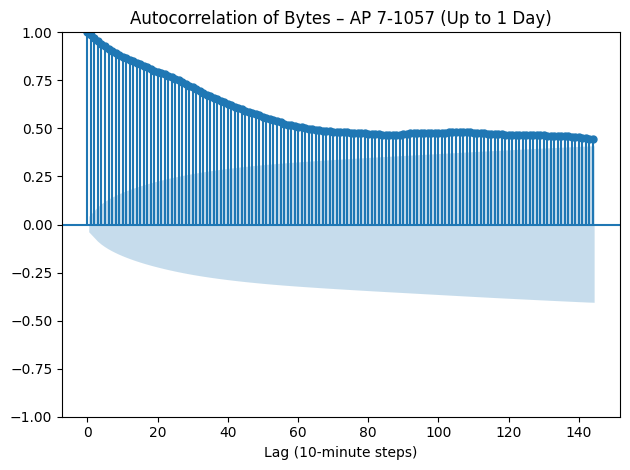

<Figure size 1200x400 with 0 Axes>

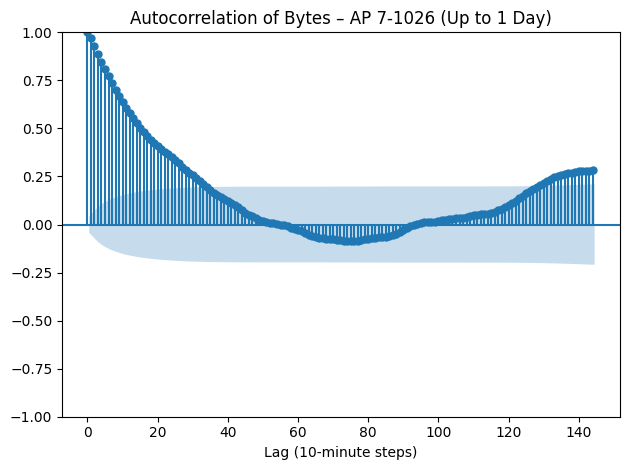

<Figure size 1200x400 with 0 Axes>

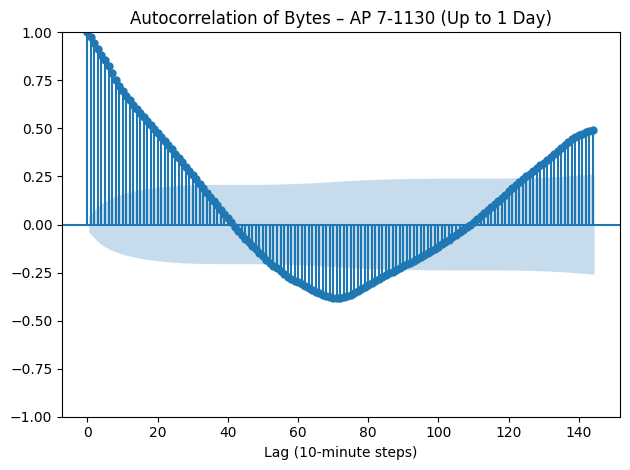

<Figure size 1200x400 with 0 Axes>

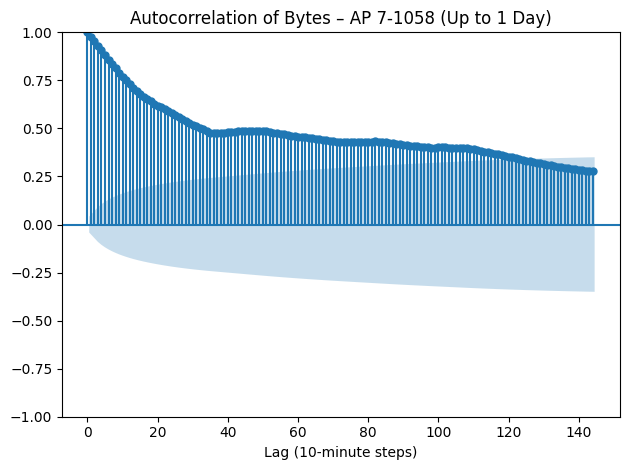

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Filter and sort
selected_df = loaded_data[loaded_data["AP ID"].isin(selected_aps)].copy()
selected_df = selected_df.sort_index()

# Autocorrelation plots with 1 day and 1 week lags
for ap_id in selected_aps:
    ap_data = selected_df[selected_df["AP ID"] == ap_id]["Bytes"]

    plt.figure(figsize=(12, 4))
    plot_acf(ap_data, lags=144, title=f"Autocorrelation of Bytes – AP {ap_id} (Up to 1 Day)")
    plt.xlabel("Lag (10-minute steps)")
    plt.tight_layout()
    plt.show()


The autocorrelation plot shows us if there are trends in the data by comparing the points with lagged versions of themselves.

We can see how APs 7-1057 and 7-1058 have some sort of downwards continuity the further the lags go, maintaining a positive autocorrelation above 0.25 for both at the 24h mark.


On the other hand, APs 7-1026 and 7-1130 show some sort of cyclic behavior of the autocorrelation in a period of something longer than the 24h mark. Both of those APs have a negative autocorrelation after 50 and 40 time lags respectively, and recover a positive autocorrelation after 90 and 110 time lags respectively. This means that for AP 7-1026 the autocorrelation switches after approximately an 8h shift and AP 7-1130 after approximately a 12h shift.

Now, we will expand on the autocorrelations, by inspecting up to a week of lags.

<Figure size 1200x400 with 0 Axes>

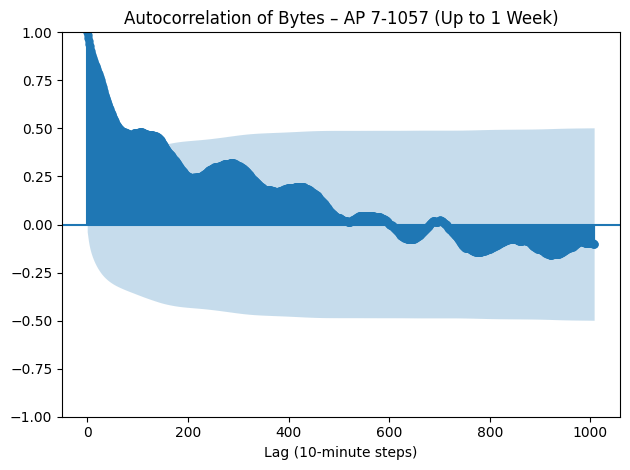

<Figure size 1200x400 with 0 Axes>

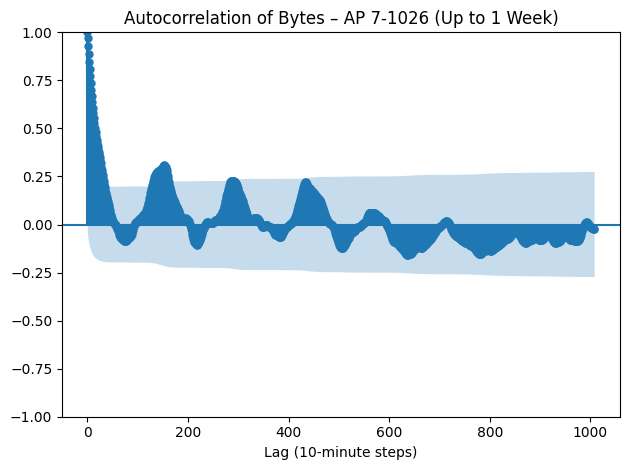

<Figure size 1200x400 with 0 Axes>

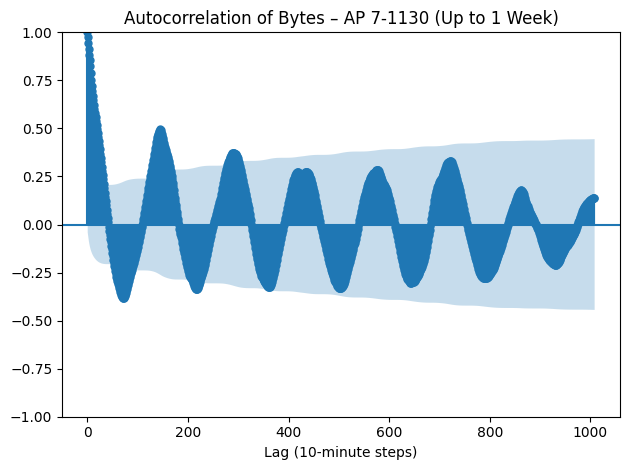

<Figure size 1200x400 with 0 Axes>

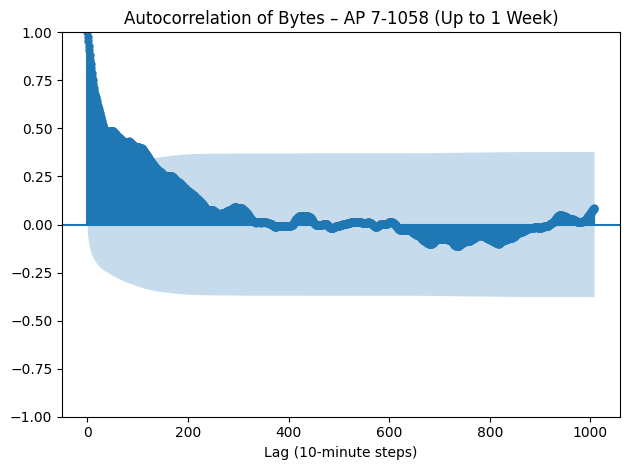

In [19]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Filter and sort
selected_df = loaded_data[loaded_data["AP ID"].isin(selected_aps)].copy()
selected_df = selected_df.sort_index()

# Autocorrelation plots with 1 day and 1 week lags
for ap_id in selected_aps:
    ap_data = selected_df[selected_df["AP ID"] == ap_id]["Bytes"]

    plt.figure(figsize=(12, 4))
    plot_acf(ap_data, lags=1008, title=f"Autocorrelation of Bytes – AP {ap_id} (Up to 1 Week)")
    plt.xlabel("Lag (10-minute steps)")
    plt.tight_layout()
    plt.show()


With the autocorrelation plots of a single week of lags, we can see how the data behaves by adding an increasing amount of day shifts.

As seen before during a day, APs 7-1026 and 7-1130 are cyclic.

AP 7-1130 presents it's cycles every approximately 24h of lags.

AP 7-1026 doesn't have that strongly defined of cycles in term of the absolute value of the autocorrelation. Additionally it indicates a decay in autocorrelation value, probably because of the Golden week influence during lags.

#### **Augmented Dickey-Fuller test**

Now let's check numerically if the series are stationary or not. For that purpose, we will conduct augmented Dickey-Fuller tests on the selected APs.

In [20]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test for each AP's Bytes time series
for ap_id in selected_aps:
    ap_data = loaded_data[loaded_data["AP ID"] == ap_id]["Bytes"].dropna()
    print("-"*40)
    print(f"\n--- ADF Test for AP {ap_id} ---")
    result = adfuller(ap_data)
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.10f}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value:.4f}")

    if result[1] < 0.05:
        print("The series is likely stationary (reject H₀).")
    else:
        print("The series is likely non-stationary (fail to reject H₀).")
    print("-"*40)


----------------------------------------

--- ADF Test for AP 7-1057 ---
ADF Statistic: -3.2982
p-value: 0.0149583717
Critical Value (1%): -3.4331
Critical Value (5%): -2.8628
Critical Value (10%): -2.5674
The series is likely stationary (reject H₀).
----------------------------------------
----------------------------------------

--- ADF Test for AP 7-1026 ---
ADF Statistic: -6.5256
p-value: 0.0000000102
Critical Value (1%): -3.4334
Critical Value (5%): -2.8629
Critical Value (10%): -2.5675
The series is likely stationary (reject H₀).
----------------------------------------
----------------------------------------

--- ADF Test for AP 7-1130 ---
ADF Statistic: -5.8640
p-value: 0.0000003359
Critical Value (1%): -3.4333
Critical Value (5%): -2.8628
Critical Value (10%): -2.5675
The series is likely stationary (reject H₀).
----------------------------------------
----------------------------------------

--- ADF Test for AP 7-1058 ---
ADF Statistic: -4.9506
p-value: 0.0000277669
Critic

It looks like the four APs selected are all stationary. AP 7-1057 has a high p-value, but still is suspected to be stationary nonetheless.

### **Exercise 2:**
***
Prepare the data to be presented as a time series to the ML model. For that, you will have to split features from samples by differentiating between an observation window (e.g., 10 samples) and a prediction window (e.g., 2 samples). Use a sliding window to iterate over all the samples.

Example: For an array [0,1,2,3,4,5], using an observation window $T_o$ = 3 and a prediction window $T_p$ = 1 would lead to the following time series data:
* $x_1$ = [0,1,2], $y_1$ = [3]
* $x_2$ = [1,2,3], $x_2$ = [4]
* $x_3$ = [2,3,4], $y_3$ = [5]

(where x are the features and y the labels)
***

#### **Sliding Windows function**

We create our general purpose sliding windows function to convert data passed into numpy arrays for features (X) and labels (Y).

In [21]:
def create_multivariate_sliding_windows(data, T_o=10, T_p=2):
  X, Y = [], []

  for i in range(len(data) - T_o - T_p + 1):
      x = data[i : i + T_o]
      y = data[i + T_o : i + T_o + T_p]
      X.append(x)
      Y.append(y)

  return np.array(X), np.array(Y)

### **Exercise 3:**
***
Split the time series data into train, test, and validation, based on your criteria.
***

#### **Split per AP function**

WE define a function to process the dataset per AP, as to respect time continituity and different range of measurements of each AP.

In [22]:
def process_AP(ap_df, T_o=10, T_p=2, train_ratio=0.7, val_ratio=0.15):
  ap_df = ap_df.sort_index()

  # Apply logn(1 + x) to the Bytes to reduce the scale.
  ap_df["Bytes_log"] = np.log1p(ap_df["Bytes"])

  # Select values from the features of this AP.
  features = ["Bytes_log", "Active Connections", "Active Users"]
  ap_values = ap_df[features].values

  # Get the number of elements of each split.
  n = len(ap_values)
  train_end = int(n * train_ratio)
  val_end = train_end + int((n * val_ratio))

  # Create the split dataframes with the number of values previously selected.
  train_data = ap_values[:train_end]
  val_data = ap_values[train_end:val_end]
  test_data = ap_values[val_end:]

  # Fit the scaler to the training data and transform the splits.
  scaler = StandardScaler()
  train_scaled = scaler.fit_transform(train_data)
  val_scaled = scaler.transform(val_data)
  test_scaled = scaler.transform(test_data)

  # Create multivariate sliding windows of each split.
  X_train, Y_train = create_multivariate_sliding_windows(train_scaled, T_o, T_p)
  X_val, Y_val = create_multivariate_sliding_windows(val_scaled, T_o, T_p)
  X_test, Y_test = create_multivariate_sliding_windows(test_scaled, T_o, T_p)

  return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler


#### **Computing subdatasets**

We compute every split of train,val,test for each AP dataset in this section.

In [23]:
# Group the dataframes by AP ID.
ap_dfs = loaded_data.groupby("AP ID")

scalers = {}

centralized_X_train, centralized_Y_train = [], []
ap_ids_train = []

centralized_X_val, centralized_Y_val = [], []
ap_ids_val = []

centralized_X_test, centralized_Y_test = [], []
ap_ids_test = []

T_o = 10
T_p = 2

for ap_id, ap_df in ap_dfs:
  try:
    X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = process_AP(ap_df, T_o, T_p)

    # Centralized arrays contains the different relevant datasets selected from diferent APs.
    # ap_ids is an array with the AP ID repeated for the length of the AP dataframe.
    centralized_X_train.append(X_train)
    centralized_Y_train.append(Y_train)
    ap_ids_train.extend([ap_id] * len(X_train))

    centralized_X_val.append(X_val)
    centralized_Y_val.append(Y_val)
    ap_ids_val.extend([ap_id] * len(X_val))

    centralized_X_test.append(X_test)
    centralized_Y_test.append(Y_test)
    ap_ids_test.extend([ap_id] * len(X_test))

    # Scalers contains all the scalers used so that it can be reversed after.
    scalers[ap_id] = scaler

  except Exception as e:
    print(f"Skipping AP {ap_id} due to error: {e}")



#### **Generating centralized dataset splits**

We concatenate every AP dataset generated for each train/val/test into a single centralized dataset for each train/val/test to feed to our models.

In [24]:
# Creating the full centralized datasets by concatenating the different train, val and test datasets
X_train = np.concatenate(centralized_X_train, axis=0)
Y_train = np.concatenate(centralized_Y_train, axis=0)

X_val   = np.concatenate(centralized_X_val, axis=0)
Y_val   = np.concatenate(centralized_Y_val, axis=0)

X_test  = np.concatenate(centralized_X_test, axis=0)
Y_test  = np.concatenate(centralized_Y_test, axis=0)


### **Exercise 4:**
***
Define a model (e.g., GRU, LSTM, CNN, Transformer) able to receive the time series the data you generated in the previous exercise.
***

#### **Dataset class definition**

We define our Dataset class capable of holding features, labels, and AP ID as to be able to inverse the transformations done per AP.

In [25]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y, ap_ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.ap_ids = ap_ids

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return input and target for given index
        return self.X[idx], self.Y[idx], self.ap_ids[idx]

#### **CNN model**

We have tried using both a CNN model and an LSTM model.

First, we have defined the CNN model.

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self, num_features, T_o, T_p):
        super(SimpleCNN, self).__init__()
        # Input shape: (batch, channels=num_features, seq_len=T_o)
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(64, 32, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * T_o, T_p * num_features)  # Predict T_p steps, each with num_features

        # Save dims for reshaping output later
        self.T_p = T_p
        self.num_features = num_features

    def forward(self, x):
        # x shape: (batch, T_o, num_features)
        # CNN expects (batch, channels, seq_len)
        x = x.permute(0, 2, 1)  # swap to (batch, features, seq_len)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc1(x)
        # reshape to (batch, T_p, num_features)
        x = x.view(-1, self.T_p, self.num_features)
        return x

#### **Evaluation (normalized) function**

We define our function to compute normalized metrics on test set.

In [27]:
# Helper function to evaluate using the test dataset
def evaluate_on_test(model, test_loader, device='cpu'):
    # Set to evaluation (switch from training)
    model.eval()
    model.to(device)

    total_mse, total_mae, total_mape = 0.0, 0.0, 0.0
    total_samples = 0

    with torch.no_grad():
        for X_batch, Y_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            preds = model(X_batch)

            # Compute metrics
            mse = nn.functional.mse_loss(preds, Y_batch, reduction='sum')
            mae = nn.functional.l1_loss(preds, Y_batch, reduction='sum')
            mape = torch.abs((Y_batch - preds) / (Y_batch + 1e-8))  # Avoid division by zero
            mape = torch.sum(mape)

            total_mse += mse.item()
            total_mae += mae.item()
            total_mape += mape.item()
            total_samples += Y_batch.numel()

    avg_mse = total_mse / total_samples
    avg_mae = total_mae / total_samples
    avg_mape = (total_mape / total_samples) * 100  # in percent

    print(f"\nTest Results:")
    print(f" MSE  = {avg_mse:.6f}")
    print(f" MAE  = {avg_mae:.6f}")
    print(f" MAPE = {avg_mape:.2f}%")

    return avg_mse, avg_mae, avg_mape


#### **Evaluation (denormalized) definition**


We define our function to compute denormalized metrics on test set.

In [28]:
def evaluate_model_with_denorm(model, test_loader, scalers, device, feature_names, log_transformed_features):
    model.eval()

    all_preds = []
    all_trues = []
    all_ap_ids = []

    with torch.no_grad():
        for X_batch, Y_batch, ap_ids_batch in test_loader:
            # Sends the data to the device (CPU or GPU)
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # Predicts based on input data, and retrieves the data from the CPU as a numpy array
            Y_pred = model(X_batch)
            Y_pred_np = Y_pred.cpu().numpy()
            Y_true_np = Y_batch.cpu().numpy()

            # Appends the results to the arrays.
            all_preds.append(Y_pred_np)
            all_trues.append(Y_true_np)
            all_ap_ids.extend(ap_ids_batch)

    # Concatenate batches
    all_preds = np.concatenate(all_preds, axis=0)  # shape (num_samples, T_p, num_features)
    all_trues = np.concatenate(all_trues, axis=0)  # same shape

    # Flatten time windows and features for inverse transform: (num_samples*T_p, num_features)
    num_samples, T_p, num_features = all_preds.shape
    all_preds_flat = all_preds.reshape(-1, num_features)
    all_trues_flat = all_trues.reshape(-1, num_features)

    # Dictionary to store denormalized preds/trues per AP
    preds_by_ap = {}
    trues_by_ap = {}

    # For each AP, inverse transform and apply expm1 to log-transformed features
    for ap_id in set(all_ap_ids):
        indices = [i for i, x in enumerate(all_ap_ids) if x == ap_id]

        # Because ap_id maps to multiple samples with T_p steps,
        # we find the start and end indices in the flattened arrays:
        # Each sample corresponds to T_p rows, so indices expand to range in flattened arrays:
        idxs_expanded = []
        for idx in indices:
            start = idx * T_p
            idxs_expanded.extend(range(start, start + T_p))

        # Select data for this AP
        preds_ap = all_preds_flat[idxs_expanded, :]
        trues_ap = all_trues_flat[idxs_expanded, :]

        # Inverse transform using the AP's scaler
        scaler = scalers[ap_id]
        preds_inv = scaler.inverse_transform(preds_ap)
        trues_inv = scaler.inverse_transform(trues_ap)

        # Reverse log1p for specified features
        for i, feat in enumerate(feature_names):
            if feat in log_transformed_features:
                preds_inv[:, i] = np.expm1(preds_inv[:, i])
                trues_inv[:, i] = np.expm1(trues_inv[:, i])

        preds_by_ap[ap_id] = preds_inv
        trues_by_ap[ap_id] = trues_inv

    # Aggregate metrics over all APs
    mse_list = []
    mae_list = []
    mape_list = []

    for ap_id in preds_by_ap.keys():
        y_pred = preds_by_ap[ap_id]
        y_true = trues_by_ap[ap_id]

        mse_list.append(mean_squared_error(y_true, y_pred))
        mae_list.append(mean_absolute_error(y_true, y_pred))

        # Calculate MAPE carefully to avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            mape = np.abs((y_true - y_pred) / y_true)
            mape = mape[~np.isinf(mape)]
            mape = mape[~np.isnan(mape)]
            mape = np.mean(mape) * 100 if len(mape) > 0 else np.nan
        mape_list.append(mape)

    results = {
        "MSE_mean": np.mean(mse_list),
        "MAE_mean": np.mean(mae_list),
        "MAPE_mean": np.nanmean(mape_list),
        "MSE_per_AP": mse_list,
        "MAE_per_AP": mae_list,
        "MAPE_per_AP": mape_list
    }

    return results

#### **LSTM model**

Now, we define the LSTM model.

In [29]:
class CentralizedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, output_size=None, T_p=2):
        super(CentralizedLSTM, self).__init__()
        self.T_p = T_p
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        if output_size is None:
            output_size = input_size  # predict same number of features

        self.fc = nn.Linear(hidden_size, output_size * T_p)

    def forward(self, x):
        batch_size = x.size(0)
        _, (hn, _) = self.lstm(x)  # hn: (num_layers, batch, hidden)
        hn = hn[-1]  # take last layer's output
        out = self.fc(hn)  # (batch, output_size * T_p)
        return out.view(batch_size, self.T_p, -1)  # reshape to (batch, T_p, output_size)

def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-3):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  for epoch in range(num_epochs):
      model.train()
      train_loss = 0.0
      for X_batch, Y_batch, _ in train_loader:
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          optimizer.zero_grad()
          output = model(X_batch)
          loss = criterion(output, Y_batch)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

      train_loss /= len(train_loader)

      # Validation loss
      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for X_val_batch, Y_val_batch, _ in val_loader:
              X_val_batch = X_val_batch.to(device)
              Y_val_batch = Y_val_batch.to(device)
              output = model(X_val_batch)
              val_loss += criterion(output, Y_val_batch).item()
      val_loss /= len(val_loader)

      print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")



### **Exercise 5:**
***
Train your model following two approaches:
1. **Centralized model training:** Mix data from multiple APs to train the model in a centralized fashion.
2. **Federated model training:** Consider APs as independent clients who contribute to training a global model by submitting local model updates.

Show the results by calculating the following metrics from the de-normalized data:
* Mean squared error (MSE)
* Mean absolute error (MAE)
* Mean absolute percentage error (MAPE)
***

#### **Centralized approach**

##### **CNN performance**

First we run the training loop for the CNN model.

In [30]:
batch_size = 32

train_dataset = TimeSeriesDataset(X_train, Y_train, ap_ids_train)
val_dataset = TimeSeriesDataset(X_val, Y_val, ap_ids_test)
test_dataset = TimeSeriesDataset(X_test, Y_test, ap_ids_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_features = X_train.shape[2]  # Features dimension
model = SimpleCNN(num_features=num_features, T_o=T_o, T_p=T_p)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [31]:
train_losses = []
val_losses = []

# Helper function: train one epoch
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    # Do for every AP
    for X_batch, Y_batch, APID_batch in dataloader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Helper function: validate one epoch
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch, APID_batch in dataloader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20

# Train, validate and print the loss results epoch by epoch
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_one_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")


Epoch 01: Train Loss = 0.276565, Val Loss = 0.326438
Epoch 02: Train Loss = 0.259507, Val Loss = 0.313700
Epoch 03: Train Loss = 0.255341, Val Loss = 0.300935
Epoch 04: Train Loss = 0.253593, Val Loss = 0.314714
Epoch 05: Train Loss = 0.251769, Val Loss = 0.305549
Epoch 06: Train Loss = 0.251062, Val Loss = 0.301695
Epoch 07: Train Loss = 0.248649, Val Loss = 0.315152
Epoch 08: Train Loss = 0.248521, Val Loss = 0.302812
Epoch 09: Train Loss = 0.246932, Val Loss = 0.298498
Epoch 10: Train Loss = 0.246857, Val Loss = 0.301484
Epoch 11: Train Loss = 0.245022, Val Loss = 0.298746
Epoch 12: Train Loss = 0.243926, Val Loss = 0.297473
Epoch 13: Train Loss = 0.243298, Val Loss = 0.306611
Epoch 14: Train Loss = 0.242156, Val Loss = 0.314977
Epoch 15: Train Loss = 0.241421, Val Loss = 0.304340
Epoch 16: Train Loss = 0.240712, Val Loss = 0.313565
Epoch 17: Train Loss = 0.240329, Val Loss = 0.305528
Epoch 18: Train Loss = 0.239069, Val Loss = 0.314662
Epoch 19: Train Loss = 0.238896, Val Loss = 0.

Now, we plot the resulting learning curve.

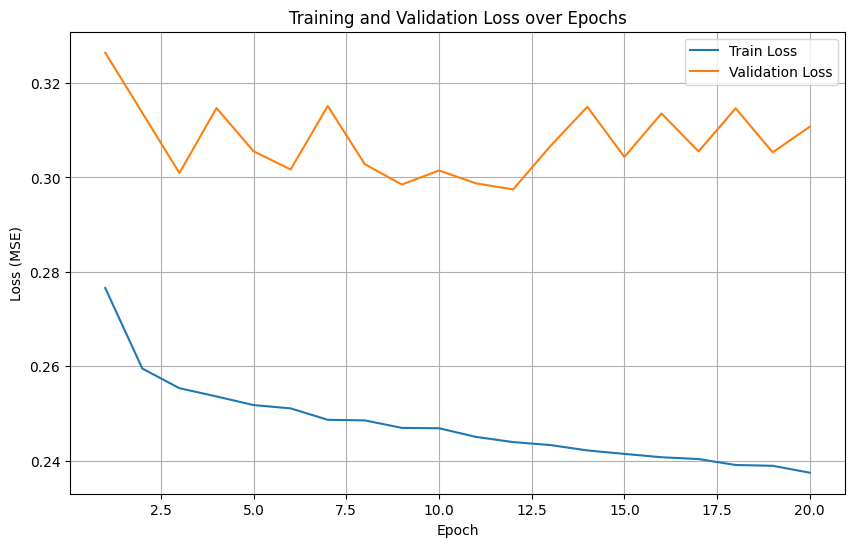

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Now, we evaluate on test dataset with normalized metrics.

In [33]:
evaluate_on_test(model, test_loader)


Test Results:
 MSE  = 0.239157
 MAE  = 0.182180
 MAPE = 1114226.10%


(0.23915705443396634, 0.18217958771346762, 1114226.0981766884)

Finally, we print the denormalized test metrics for the centralized model.

In [34]:
feature_names = ["Bytes", "Active Connections", "Active Users"]
log_transformed_features = ["Bytes"]  # features we applied log1p to

results = evaluate_model_with_denorm(
    model,
    test_loader,
    scalers=scalers,           # dict with keys like 'AP1_1', 'AP1_2', etc.
    device=device,
    feature_names=feature_names,
    log_transformed_features=log_transformed_features
)
print("Denormalized Test metrics:")
print(f'MSE: {results["MSE_mean"]}')
print(f'MAE: {results["MAE_mean"]}')
print(f'MAPE: {results["MAPE_mean"]} %')

Denormalized Test metrics:
MSE: 1296064924.0933213
MAE: 3053.23886349326
MAPE: 36054417408.0 %


We observe what we think are relatively good values in the denormalized metrics, taking into account Bytes feature is in the order of 1e6, meaning that our MAE is not that high with thsi value on mind, and MSE is understandable with that magnitude.

##### **LSTM performance**

And then we conduct training with LSTM model.

In [35]:
train_dataset = TimeSeriesDataset(X_train, Y_train, ap_ids_train)
val_dataset = TimeSeriesDataset(X_val, Y_val, ap_ids_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

input_size = X_train.shape[-1]
model = CentralizedLSTM(input_size=input_size, output_size=input_size, T_p=Y_train.shape[1])
train_model(model, train_loader, val_loader)

Epoch 1/20 | Train Loss: 0.2767 | Val Loss: 0.3267
Epoch 2/20 | Train Loss: 0.2596 | Val Loss: 0.3130
Epoch 3/20 | Train Loss: 0.2549 | Val Loss: 0.3147
Epoch 4/20 | Train Loss: 0.2523 | Val Loss: 0.3167
Epoch 5/20 | Train Loss: 0.2496 | Val Loss: 0.3244
Epoch 6/20 | Train Loss: 0.2477 | Val Loss: 0.3176
Epoch 7/20 | Train Loss: 0.2464 | Val Loss: 0.3115
Epoch 8/20 | Train Loss: 0.2431 | Val Loss: 0.3125
Epoch 9/20 | Train Loss: 0.2404 | Val Loss: 0.3089
Epoch 10/20 | Train Loss: 0.2382 | Val Loss: 0.3132
Epoch 11/20 | Train Loss: 0.2355 | Val Loss: 0.3207
Epoch 12/20 | Train Loss: 0.2315 | Val Loss: 0.3154
Epoch 13/20 | Train Loss: 0.2279 | Val Loss: 0.3161
Epoch 14/20 | Train Loss: 0.2245 | Val Loss: 0.3213
Epoch 15/20 | Train Loss: 0.2205 | Val Loss: 0.3159
Epoch 16/20 | Train Loss: 0.2174 | Val Loss: 0.3218
Epoch 17/20 | Train Loss: 0.2124 | Val Loss: 0.3280
Epoch 18/20 | Train Loss: 0.2076 | Val Loss: 0.3220
Epoch 19/20 | Train Loss: 0.2037 | Val Loss: 0.3195
Epoch 20/20 | Train L

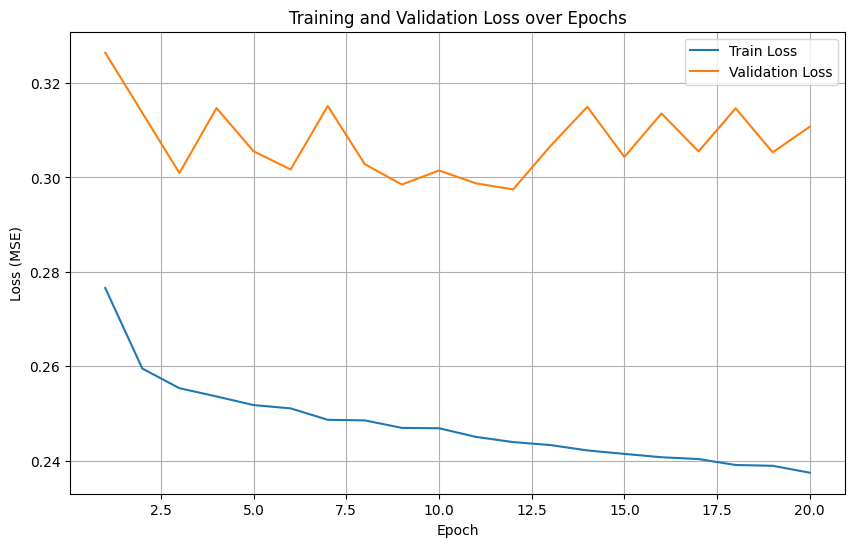

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
evaluate_on_test(model, test_loader)


Test Results:
 MSE  = 0.252488
 MAE  = 0.182371
 MAPE = 1033845.41%


(0.2524878518233567, 0.18237149750692988, 1033845.4092624917)

In [38]:
feature_names = ["Bytes", "Active Connections", "Active Users"]
log_transformed_features = ["Bytes"]  # features we applied log1p to

results = evaluate_model_with_denorm(
    model,
    test_loader,
    scalers=scalers,           # dict with keys like 'AP1_1', 'AP1_2', etc.
    device=device,
    feature_names=feature_names,
    log_transformed_features=log_transformed_features
)
print("Denormalized Test metrics:")
print(f'MSE: {results["MSE_mean"]}')
print(f'MAE: {results["MAE_mean"]}')
print(f'MAPE: {results["MAPE_mean"]} %')

Denormalized Test metrics:
MSE: 4778824346.491922
MAE: 3335.8905547008662
MAPE: 55544942592.0 %


So, after our experiments the test losses are:


**DENORMALIZED**

**CNN**

* MSE = 934,054,137.3492038

* MAE = 2,600.2169570172114

* MAPE = 52,771,323,904.0 %

**LSTM**


* MSE = 4,015,163,659.3981395

* MAE = 3,003.141121453438

* MAPE = 63,759,527,936.0 %


Overall, the LSTM had worse denormalized metrics.

#### **Federated Learning**

For federated learning, we use a similar Dataset without the AP IDs and reuse the model (LSTM).

In [39]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        # Expect numpy arrays
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return input and target for given index
        return self.X[idx], self.Y[idx]


We apply an algorithm to score AP datasets based on the amount of connections and bytes transmitted, although the scoring could be better as it may underrepresent situations with low activity.

In [40]:
# The selection algorithm is based on a score. We calculate a score for each AP so that APs with higher transmission of bytes, active connections, and
# active users have a higher probability of being selected.

import numpy as np
import pandas as pd

# --- Parameters ---
bytes_weight = 0.5
users_weight = 0.3
connections_weight = 0.2
p_min = 0.05  # Every AP has a minimum selection probability for fairness

# The score is computed against the max of each feature and multiplied by the weight given.
agg_values['score_raw'] = (
    bytes_weight * (agg_values['Bytes_sum'] / agg_values['Bytes_sum'].max()) +
    users_weight * (agg_values['Active Users_mean'] / agg_values['Active Users_mean'].max()) +
    connections_weight * (agg_values['Active Connections_mean'] / agg_values['Active Connections_mean'].max())
)

# --- Scale scores to [p_min, 1] ---
score_min = agg_values['score_raw'].min()
score_max = agg_values['score_raw'].max()


if score_max - score_min > 1e-6:
    agg_values['ap_score'] = p_min + (1 - p_min) * ((agg_values['score_raw'] - score_min) / (score_max - score_min))
else:
    agg_values['ap_score'] = 1.0  # If all scores are identical

# --- Result: AP selection probabilities ---
ap_selection_probabilities = agg_values[['AP ID', 'ap_score']]

print(ap_selection_probabilities)

     AP ID  ap_score
0     7-10  0.064466
1    7-100  0.058397
2   7-1002  0.116603
3   7-1003  0.282161
4   7-1004  0.275185
..     ...       ...
95  7-1134  0.074320
96  7-1136  0.054792
97  7-1137  0.113157
98  7-1139  0.173922
99   7-114  0.058190

[100 rows x 2 columns]


For federated learning, we create datasets for each AP using pivot dataframes, which are dataframes in which each row has the feature values of every AP.

In [41]:
def create_ap_specific_datasets(loaded_data, T_o=10, T_p=2, features=None):
    """
    Create separate datasets for each AP
    Returns: dict {ap_id: (X, Y)}
    """
    if features is None:
        features = ["Bytes", "Active Connections", "Active Users"]

    ap_datasets = {}
    unique_aps = loaded_data['AP ID'].unique()

    for ap_id in unique_aps:
        # Filter by AP ID
        ap_data = loaded_data[loaded_data['AP ID'] == ap_id]
        # Create a pivot dataframe using the time series as index
        # Set the columns to the feature of every AP and set all NaN (the AP was off) to 0.
        pivot_df = ap_data.pivot_table(index=ap_data.index, columns='AP ID', values=features)
        pivot_df.columns = [f"{ap}_{feat}" for feat, ap in pivot_df.columns]
        pivot_df = pivot_df.fillna(0)
        data = pivot_df.values

        # Create the sliding window
        X, Y = [], []
        for i in range(len(data) - T_o - T_p + 1):
            x = data[i : i + T_o]
            y = data[i + T_o : i + T_o + T_p]
            X.append(x)
            Y.append(y)

        ap_datasets[ap_id] = (np.array(X), np.array(Y))

    return ap_datasets

# Create AP-specific datasets
ap_datasets = create_ap_specific_datasets(loaded_data, T_o, T_p, features)

In [42]:
def prepare_ap_datasets_with_normalization(loaded_data, T_o=10, T_p=2, features=None,
                                         test_ratio=0.2, val_ratio=0.1):
    """
    Create normalized datasets for each AP with train/val/test splits
    Returns:
        dict {
            ap_id: {
                'train': (X_train, Y_train),
                'val': (X_val, Y_val),
                'test': (X_test, Y_test),
                'scalers': (X_scaler, Y_scaler)
            }
        }
    """
    if features is None:
        features = ["Bytes", "Active Connections", "Active Users"]

    ap_datasets = {}
    unique_aps = loaded_data['AP ID'].unique()

    for ap_id in unique_aps:
        # Filter by AP ID
        ap_data = loaded_data[loaded_data['AP ID'] == ap_id]
        # Create a pivot dataframe using the time series as index
        # Set the columns to the feature of every AP and set all NaN (the AP was off) to 0.
        pivot_df = ap_data.pivot_table(index=ap_data.index, columns='AP ID', values=features)
        pivot_df.columns = [f"{ap}_{feat}" for feat, ap in pivot_df.columns]
        pivot_df = pivot_df.fillna(0)
        data = pivot_df.values

        # Create sliding windows
        X, Y = [], []
        for i in range(len(data) - T_o - T_p + 1):
            x = data[i : i + T_o]
            y = data[i + T_o : i + T_o + T_p]
            X.append(x)
            Y.append(y)

        X, Y = np.array(X), np.array(Y)

        # Split into train/val/test
        total_samples = len(X)
        test_split = int(total_samples * (1 - test_ratio))
        val_split = int(test_split * (1 - val_ratio))

        X_train, Y_train = X[:val_split], Y[:val_split]
        X_val, Y_val = X[val_split:test_split], Y[val_split:test_split]
        X_test, Y_test = X[test_split:], Y[test_split:]

        # Normalize each split separately
        def normalize_ap_data(X_train, X_val, X_test, Y_train, Y_val, Y_test):
            # Apply log1p and standard scaling
            def scale_data(data, scaler=None, fit=False):
                data = np.log1p(data)
                if fit:
                    scaler = StandardScaler()
                    scaled = scaler.fit_transform(data.reshape(-1, 1))
                else:
                    scaled = scaler.transform(data.reshape(-1, 1))
                return scaled.reshape(data.shape), scaler

            # Normalize X features
            X_scalers = []
            for i in range(X_train.shape[-1]):
                X_train[:, :, i], x_scaler = scale_data(
                    X_train[:, :, i], fit=True
                )
                X_val[:, :, i], _ = scale_data(
                    X_val[:, :, i], scaler=x_scaler
                )
                X_test[:, :, i], _ = scale_data(
                    X_test[:, :, i], scaler=x_scaler
                )
                X_scalers.append(x_scaler)

            # Normalize Y features
            Y_scalers = []
            for i in range(Y_train.shape[-1]):
                Y_train[:, :, i], y_scaler = scale_data(
                    Y_train[:, :, i], fit=True
                )
                Y_val[:, :, i], _ = scale_data(
                    Y_val[:, :, i], scaler=y_scaler
                )
                Y_test[:, :, i], _ = scale_data(
                    Y_test[:, :, i], scaler=y_scaler
                )
                Y_scalers.append(y_scaler)

            return X_train, X_val, X_test, Y_train, Y_val, Y_test, X_scalers, Y_scalers

        # Apply normalization
        (X_train_norm, X_val_norm, X_test_norm,
         Y_train_norm, Y_val_norm, Y_test_norm,
         X_scalers, Y_scalers) = normalize_ap_data(
             X_train, X_val, X_test, Y_train, Y_val, Y_test
         )

        # Store in dictionary
        ap_datasets[ap_id] = {
            'train': (X_train_norm, Y_train_norm),
            'val': (X_val_norm, Y_val_norm),
            'test': (X_test_norm, Y_test_norm),
            'scalers': (X_scalers, Y_scalers)
        }

    return ap_datasets

After defining the functions, we define the FL model.

In [43]:
# Defining the Federated algorithm
# ==================== FL Client ====================

class FLClient:
    def __init__(self, ap_id, train_data, model_class, T_o, T_p):
        self.ap_id = ap_id
        self.X_train, self.Y_train = train_data
        self.model = model_class(num_features=self.X_train.shape[-1], T_o=T_o, T_p=T_p)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.criterion = nn.MSELoss()

    def train(self, epochs=1):
        dataset = TimeSeriesDataset(self.X_train, self.Y_train)
        loader = DataLoader(dataset, batch_size=32, shuffle=True)

        self.model.train()
        total_loss = 0
        total_samples = 0

        for epoch in range(epochs):
            for x_batch, y_batch in loader:
                self.optimizer.zero_grad()
                outputs = self.model(x_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item() * x_batch.size(0)
                total_samples += x_batch.size(0)

        avg_loss = total_loss / total_samples
        # model.state_dict() are the weights and biases
        return self.model.state_dict(), total_samples, avg_loss


# ==================== FL Server ====================

class FLServer:
    def __init__(self, model_class, T_o, T_p, num_features_per_ap, ap_probs):
        self.global_model = model_class(num_features=num_features_per_ap, T_o=T_o, T_p=T_p)
        self.ap_probs = ap_probs
        self.criterion = nn.MSELoss()

    def select_clients(self, ap_datasets, frac=0.3):
        all_aps = list(ap_datasets.keys())
        # Select the probabilities from the different APs
        probs = np.array([self.ap_probs[ap] for ap in all_aps])
        probs = probs / probs.sum()  # Normalize
        # Does a random selection with the probabilities
        selected = np.random.choice(all_aps, size=int(frac*len(all_aps)), p=probs, replace=False)
        return selected

    # Updates the weights and biases with the client updates
    def aggregate(self, client_updates):
        total_samples = sum([num_samples for _, num_samples in client_updates.values()])
        new_state = {}

        for key in client_updates[list(client_updates.keys())[0]][0].keys():
            new_state[key] = torch.zeros_like(self.global_model.state_dict()[key])

        for ap_id, (state_dict, num_samples) in client_updates.items():
            weight = num_samples / total_samples
            for key in state_dict.keys():
                new_state[key] += weight * state_dict[key]

        self.global_model.load_state_dict(new_state)

    # Performs a federated round
    def federated_round(self, ap_datasets, epochs=1):
        selected_aps = self.select_clients(ap_datasets)
        client_updates = {}
        train_losses = []
        total_samples = 0

        for ap_id in selected_aps:
            # Instantiates a Client model and loads the global weights and biases
            client = FLClient(ap_id, ap_datasets[ap_id]['train'], type(self.global_model), T_o, T_p)
            client.model.load_state_dict(self.global_model.state_dict())
            # Trains the local client
            state_dict, num_samples, train_loss = client.train(epochs=epochs)
            # Saves the client updates
            client_updates[ap_id] = (state_dict, num_samples)
            # Appends the total train loss
            train_losses.append(train_loss * num_samples)
            # Updates the total samples of the round
            total_samples += num_samples

        # Performs global weights and biases update and returns the selected APs and average training loss
        avg_train_loss = sum(train_losses) / total_samples
        self.aggregate(client_updates)
        return selected_aps, avg_train_loss


    # Performs evaluation using all validation splits and returns the total loss
    def evaluate(self, ap_datasets, split='val'):
        self.global_model.eval()
        total_loss = 0
        total_samples = 0

        for ap_id, data in ap_datasets.items():
            X, Y = data[split]
            dataset = TimeSeriesDataset(X, Y)
            loader = DataLoader(dataset, batch_size=32, shuffle=False)

            with torch.no_grad():
                for x_batch, y_batch in loader:
                    outputs = self.global_model(x_batch)
                    loss = self.criterion(outputs, y_batch)
                    total_loss += loss.item() * x_batch.size(0)
                    total_samples += x_batch.size(0)

        return total_loss / total_samples

    # Perform evaluation using all testing splits and returns the average loss values.
    def evaluate_metrics(self, ap_datasets, split='test'):
        self.global_model.eval()

        mse_loss = nn.MSELoss(reduction='sum')
        mae_loss = nn.L1Loss(reduction='sum')

        total_mse = 0
        total_mae = 0
        total_mape = 0
        total_samples = 0

        for ap_id, data in ap_datasets.items():
            X, Y = data[split]
            dataset = TimeSeriesDataset(X, Y)
            loader = DataLoader(dataset, batch_size=32, shuffle=False)

            with torch.no_grad():
                for x_batch, y_batch in loader:
                    outputs = self.global_model(x_batch)
                    batch_size = x_batch.size(0)

                    total_mse += mse_loss(outputs, y_batch).item()
                    total_mae += mae_loss(outputs, y_batch).item()

                    # MAPE calculation - avoid division by zero
                    y_true = y_batch.detach().cpu().numpy()
                    y_pred = outputs.detach().cpu().numpy()
                    non_zero_mask = y_true != 0
                    if non_zero_mask.any():
                        mape = (np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])).mean()
                        total_mape += mape * batch_size
                    else:
                        # If all true values are zero, skip MAPE for this batch
                        total_mape += 0

                    total_samples += batch_size

        avg_mse = total_mse / total_samples
        avg_mae = total_mae / total_samples
        avg_mape = total_mape / total_samples

        return avg_mse, avg_mae, avg_mape

    # Reverses the scaling and performs evaluation using all testing splits and returns the average loss values.
    def evaluate_metrics_with_denormalization(self, ap_datasets, split='test'):
        self.global_model.eval()

        mse_loss = nn.MSELoss(reduction='sum')
        mae_loss = nn.L1Loss(reduction='sum')

        total_mse = 0
        total_mae = 0
        total_mape = 0
        total_samples = 0

        for ap_id, data in ap_datasets.items():
            X, Y = data[split]
            _, Y_scalers = data['scalers']

            dataset = TimeSeriesDataset(X, Y)
            loader = DataLoader(dataset, batch_size=32, shuffle=False)

            with torch.no_grad():
                for x_batch, y_batch in loader:
                    outputs = self.global_model(x_batch)

                    # Convert to numpy for denormalization
                    y_true = y_batch.detach().cpu().numpy()  # shape: (batch, T_p, features)
                    y_pred = outputs.detach().cpu().numpy()

                    # Denormalize each feature separately using Y_scalers
                    for i, scaler in enumerate(Y_scalers):
                        # Inverse standard scaling
                        y_true[:, :, i] = scaler.inverse_transform(y_true[:, :, i])
                        y_pred[:, :, i] = scaler.inverse_transform(y_pred[:, :, i])

                        # Inverse log1p transform
                        y_true[:, :, i] = np.expm1(y_true[:, :, i])
                        y_pred[:, :, i] = np.expm1(y_pred[:, :, i])

                    # Now compute metrics on denormalized data
                    batch_size = y_true.shape[0]
                    total_samples += batch_size

                    # Flatten to (batch * T_p * features) for metric calculation
                    y_true_flat = y_true.reshape(-1)
                    y_pred_flat = y_pred.reshape(-1)

                    total_mse += ((y_true_flat - y_pred_flat) ** 2).sum()
                    total_mae += np.abs(y_true_flat - y_pred_flat).sum()

                    # MAPE: avoid division by zero
                    non_zero_mask = y_true_flat != 0
                    if np.any(non_zero_mask):
                        mape = np.mean(np.abs((y_true_flat[non_zero_mask] - y_pred_flat[non_zero_mask]) / y_true_flat[non_zero_mask]))
                        total_mape += mape * batch_size
                    else:
                        total_mape += 0

        avg_mse = total_mse / (total_samples * Y.shape[1] * Y.shape[2])  # total samples * T_p * features
        avg_mae = total_mae / (total_samples * Y.shape[1] * Y.shape[2])
        avg_mape = total_mape / total_samples

        return avg_mse, avg_mae, avg_mape

Now we run the federated model.

In [44]:
# ==================== Main Execution ====================

# Parameters
T_o = 10  # Observation window
T_p = 2   # Prediction window
features = ["Bytes", "Active Connections", "Active Users"]
num_features_per_ap = len(features)
num_rounds = 10
client_fraction = 0.3

# 1. Load and prepare data with normalization
ap_datasets = prepare_ap_datasets_with_normalization(
    loaded_data, T_o, T_p, features, test_ratio=0.2, val_ratio=0.1
)

# 2. Initialize server with AP selection probabilities
ap_probs = ap_selection_probabilities.set_index('AP ID')['ap_score'].to_dict()
server = FLServer(SimpleCNN, T_o, T_p, num_features_per_ap, ap_probs)

import matplotlib.pyplot as plt

# 3. Federated training with validation
best_val_loss = float('inf')
train_losses = []
val_losses = []

for round in range(num_rounds):
    selected, train_loss = server.federated_round(ap_datasets, epochs=1)
    print(f"Round {round+1}: Selected APs {selected}")
    print(f"Training loss: {train_loss:.4f}")

    val_loss = server.evaluate(ap_datasets, split='val')
    print(f"Validation loss: {val_loss:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(server.global_model.state_dict(), 'best_global_model.pth')

Round 1: Selected APs ['7-1117' '7-1056' '7-1009' '7-1085' '7-1088' '7-1114' '7-1058' '7-1079'
 '7-1023' '7-1026' '7-1082' '7-1104' '7-1102' '7-1130' '7-1048' '7-1015'
 '7-110' '7-1018' '7-1066' '7-1043' '7-1100' '7-111' '7-1121' '7-1057'
 '7-1014' '7-102' '7-1071' '7-1127' '7-10' '7-100']
Training loss: 0.4409
Validation loss: 0.4399
Round 2: Selected APs ['7-111' '7-1062' '7-1019' '7-1117' '7-1026' '7-1114' '7-1002' '7-1003'
 '7-1084' '7-1033' '7-1047' '7-1004' '7-1087' '7-1051' '7-1030' '7-1069'
 '7-1113' '7-1071' '7-1127' '7-1014' '7-1056' '7-1088' '7-1063' '7-1060'
 '7-1045' '7-1006' '7-1053' '7-1034' '7-1130' '7-1022']
Training loss: 0.2143
Validation loss: 0.3727
Round 3: Selected APs ['7-1058' '7-1034' '7-1051' '7-1137' '7-1130' '7-1048' '7-1106' '7-1026'
 '7-1079' '7-1069' '7-1002' '7-1094' '7-1063' '7-1096' '7-1074' '7-1102'
 '7-1059' '7-1066' '7-104' '7-1127' '7-1039' '7-1057' '7-1006' '7-110'
 '7-106' '7-1013' '7-1125' '7-1114' '7-1083' '7-1005']
Training loss: 0.1988
Valid

We end up with the next validation curve.

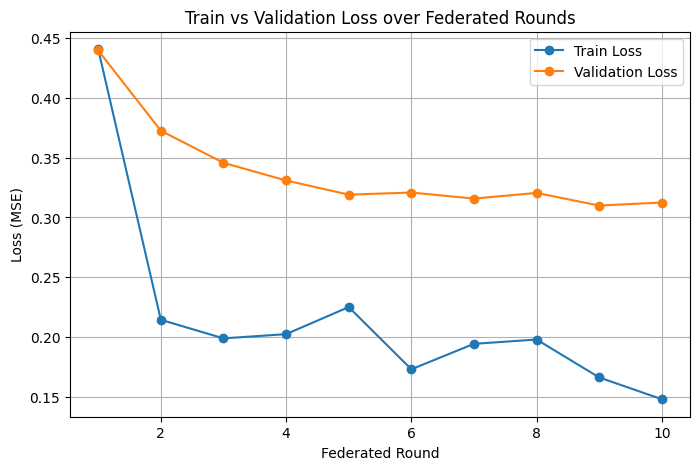

In [45]:
# Plot train vs validation loss
plt.figure(figsize=(8,5))
plt.plot(range(1, num_rounds+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_rounds+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Federated Round')
plt.ylabel('Loss (MSE)')
plt.title('Train vs Validation Loss over Federated Rounds')
plt.legend()
plt.grid(True)
plt.show()

Finally, we plot the evaluation metrics with and without normalization.

In [46]:
mse, mae, mape = server.evaluate_metrics(ap_datasets, split='test')
print(f'Without denormalization:')
print(f"- Final test MSE: {mse:.4f}")
print(f"- Final test MAE: {mae:.4f}")
print(f"- Final test MAPE: {mape:.4f}")

mse, mae, mape = server.evaluate_metrics_with_denormalization(ap_datasets, split='test')
print(f'With denormalization:')
print(f"- Final test MSE: {mse:.4f}")
print(f"- Final test MAE: {mae:.4f}")
print(f"- Final test MAPE: {mape:.4f}")


Without denormalization:
- Final test MSE: 1.7022
- Final test MAE: 1.4315
- Final test MAPE: 0.7967
With denormalization:
- Final test MSE: 821619840.0000
- Final test MAE: 3058.3884
- Final test MAPE: 1250019584.0000


Comparing with the LSTM results for Centralized approach:


**CENTRALIZED: LSTM**


* MSE = 4,015,163,659.3981395

* MAE = 3,003.141121453438

* MAPE = 63,759,527,936.0 %

**FEDERATED: LSTM**

* MSE = 821,619,840.0000

* MAE = 3,058.3884

* MAPE = 1,250,019,584.0000 %


We can see how **Federated** approach performs much better according to MAPE and MSE greatly reducing the order of those values, yet the value for MAE is slightly worse.

### **Exercise 6 (EXTRA):**
***
Reconsider your design to improve the accuracy of your model. For that, you can find a better approach to split the data (e.g., using larger observation windows) and include additional features.
***

#### **Updating split methodology**

For our new splitting, we label each day with holiday or regular. We extract the day of the week for each measurement and compute if the weekday corresponds to a weekend to add another label.

We compute blocks of normalized days, that is, grouping all measurements corresponding to a single day.

With said labels we can tag the blocks to then construct our subdatasets akin to a stratified splitting.

This way, we have a division of the dataset between holidays and regular weeks, and we further split into regular workdays and weekends. This subdivisions, respecting temporal continuity when constructing windows, will allow us to mantain a ratio of information from all timestamps in our train/val/tests splits, so we learn from holidays/regular and weekdays/weekends different patterns and check against holidays/regular and weekdays/weekends in val/test.


In no moment do we shuffle the measurements, we always keep them sorted by timestamp. After computing ratios tof train/val/test on each block they are collected in train/val/test datasets together sorted by timestamps.

In [47]:
def create_multivariate_sliding_windows(data, T_o=10, T_p=2):
    X, Y = [], []
    for i in range(len(data) - T_o - T_p + 1):
        x = data[i : i + T_o]
        y = data[i + T_o : i + T_o + T_p]
        X.append(x)
        Y.append(y)
    return np.array(X), np.array(Y)

def split_blocks(blocks, train_ratio=0.7, val_ratio=0.15):
    n = len(blocks)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    return (
        blocks[:n_train],
        blocks[n_train:n_train + n_val],
        blocks[n_train + n_val:]
    )

def split_and_process_ap(ap_df, T_o=10, T_p=2, features=["Bytes_log", "Active Connections", "Active Users"]):
    ap_df = ap_df.sort_index()

    # Label each timestamp
    ap_df['period'] = np.where(ap_df.index < pd.to_datetime('2019-05-06'), 'holiday', 'regular')
    ap_df['day_of_week'] = ap_df.index.dayofweek
    ap_df['is_weekend'] = ap_df['day_of_week'].isin([5, 6])
    ap_df["Bytes_log"] = np.log1p(ap_df["Bytes"])

    # Group into daily blocks
    daily_blocks = [g for _, g in ap_df.groupby(ap_df.index.normalize())]

    # Tag each block by (day_type, period)
    def tag_block(block):
        is_weekend = block['is_weekend'].iloc[0]
        period = block['period'].iloc[0]
        return ('weekend' if is_weekend else 'weekday', period)

    tagged_blocks = {}
    for block in daily_blocks:
        key = tag_block(block)
        tagged_blocks.setdefault(key, []).append(block) # Build array of all blocks corresponding to a key e.g. (weekend, holiday)

    # Stratified splitting
    train_blocks, val_blocks, test_blocks = [], [], []
    for blocks in tagged_blocks.values():
        b_train, b_val, b_test = split_blocks(blocks)
        train_blocks += b_train
        val_blocks += b_val
        test_blocks += b_test

    # Concatenate splits
    train_df = pd.concat(train_blocks).sort_index()
    val_df = pd.concat(val_blocks).sort_index()
    test_df = pd.concat(test_blocks).sort_index()

    # Extract feature arrays
    train_data = train_df[features].values
    val_data = val_df[features].values
    test_data = test_df[features].values

    # Normalize
    scaler = MinMaxScaler(feature_range=(1,2))
    train_scaled = scaler.fit_transform(train_data)
    val_scaled = scaler.transform(val_data)
    test_scaled = scaler.transform(test_data)

    # Create sliding windows
    X_train, Y_train = create_multivariate_sliding_windows(train_scaled, T_o, T_p)
    X_val, Y_val     = create_multivariate_sliding_windows(val_scaled, T_o, T_p)
    X_test, Y_test   = create_multivariate_sliding_windows(test_scaled, T_o, T_p)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler

Now, we try creating the datasets using these new methods.

In [48]:
centralized_X_train, centralized_Y_train = [], []
ap_ids_train = []

centralized_X_val, centralized_Y_val = [], []
ap_ids_val = []

centralized_X_test, centralized_Y_test = [], []
ap_ids_test = []

scalers = {}

for ap_id, ap_df in loaded_data.groupby("AP ID"):
    try:
        X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = split_and_process_ap(ap_df)

        centralized_X_train.append(X_train)
        centralized_Y_train.append(Y_train)
        ap_ids_train.extend([ap_id] * len(X_train))

        centralized_X_val.append(X_val)
        centralized_Y_val.append(Y_val)
        ap_ids_val.extend([ap_id] * len(X_val))

        centralized_X_test.append(X_test)
        centralized_Y_test.append(Y_test)
        ap_ids_test.extend([ap_id] * len(X_test))

        scalers[ap_id] = scaler

    except Exception as e:
        print(f"Skipping AP {ap_id} due to error: {e}")


Skipping AP 7-1020 due to error: No objects to concatenate
Skipping AP 7-1043 due to error: No objects to concatenate
Skipping AP 7-114 due to error: No objects to concatenate


In [49]:
X_train = np.concatenate(centralized_X_train, axis=0)
Y_train = np.concatenate(centralized_Y_train, axis=0)

X_val   = np.concatenate(centralized_X_val, axis=0)
Y_val   = np.concatenate(centralized_Y_val, axis=0)

X_test  = np.concatenate(centralized_X_test, axis=0)
Y_test  = np.concatenate(centralized_Y_test, axis=0)


#### **Testing new splitting with CNN (Centralized)**

We redefine our Dataset capable of holding ap_ids to undo scaling per AP.

In [50]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y, ap_ids):
        # Expect numpy arrays
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.ap_ids = ap_ids

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return input and target for given index
        return self.X[idx], self.Y[idx], self.ap_ids[idx]

We then proceed to train our CNN using the new method of splitting datasets.

In [51]:
batch_size = 32

train_dataset = TimeSeriesDataset(X_train, Y_train, ap_ids_train)
val_dataset = TimeSeriesDataset(X_val, Y_val, ap_ids_test)
test_dataset = TimeSeriesDataset(X_test, Y_test, ap_ids_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_features = X_train.shape[2]  # Features dimension (all APs * features combined)
model = SimpleCNN(num_features=num_features, T_o=T_o, T_p=T_p)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [52]:
train_losses = []
val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20  # change as you want

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate_one_epoch(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}")


Epoch 01: Train Loss = 0.013063, Val Loss = 0.012017
Epoch 02: Train Loss = 0.009204, Val Loss = 0.012045
Epoch 03: Train Loss = 0.009017, Val Loss = 0.011803
Epoch 04: Train Loss = 0.008905, Val Loss = 0.011446
Epoch 05: Train Loss = 0.008834, Val Loss = 0.011476
Epoch 06: Train Loss = 0.008758, Val Loss = 0.011457
Epoch 07: Train Loss = 0.008690, Val Loss = 0.011272
Epoch 08: Train Loss = 0.008686, Val Loss = 0.011236
Epoch 09: Train Loss = 0.008645, Val Loss = 0.011166
Epoch 10: Train Loss = 0.008619, Val Loss = 0.011193
Epoch 11: Train Loss = 0.008613, Val Loss = 0.011282
Epoch 12: Train Loss = 0.008590, Val Loss = 0.011084
Epoch 13: Train Loss = 0.008549, Val Loss = 0.011350
Epoch 14: Train Loss = 0.008558, Val Loss = 0.011255
Epoch 15: Train Loss = 0.008538, Val Loss = 0.011106
Epoch 16: Train Loss = 0.008536, Val Loss = 0.011157
Epoch 17: Train Loss = 0.008509, Val Loss = 0.011508
Epoch 18: Train Loss = 0.008504, Val Loss = 0.011408
Epoch 19: Train Loss = 0.008513, Val Loss = 0.

In [53]:
evaluate_on_test(model, test_loader)


Test Results:
 MSE  = 0.006589
 MAE  = 0.030183
 MAPE = 2.49%


(0.006588525112364142, 0.03018278837478303, 2.493904360961465)

In [54]:
feature_names = ["Bytes", "Active Connections", "Active Users"]
log_transformed_features = ["Bytes"]  # features you applied log1p to

results = evaluate_model_with_denorm(
    model,
    test_loader,
    scalers=scalers,           # dict with keys like 'AP1_1', 'AP1_2', etc.
    device=device,
    feature_names=feature_names,
    log_transformed_features=log_transformed_features
)
print("Denormalized Test metrics:")
print("Test MSE:", results["MSE_mean"])
print("Test MAE:", results["MAE_mean"])
print("Test MAPE:", results["MAPE_mean"])


Denormalized Test metrics:
Test MSE: 1156196715.6468563
Test MAE: 4121.746678968968
Test MAPE: 332174460.0


#### **Testing new splitting with LSTM (Centralized)**

We train our LSTM using the new splitting method.

In [55]:
train_dataset = TimeSeriesDataset(X_train, Y_train, ap_ids_train)
val_dataset = TimeSeriesDataset(X_val, Y_val, ap_ids_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

input_size = X_train.shape[-1]
model = CentralizedLSTM(input_size=input_size, output_size=input_size, T_p=Y_train.shape[1])
train_model(model, train_loader, val_loader)

Epoch 1/20 | Train Loss: 0.0157 | Val Loss: 0.0125
Epoch 2/20 | Train Loss: 0.0093 | Val Loss: 0.0117
Epoch 3/20 | Train Loss: 0.0090 | Val Loss: 0.0117
Epoch 4/20 | Train Loss: 0.0089 | Val Loss: 0.0119
Epoch 5/20 | Train Loss: 0.0088 | Val Loss: 0.0117
Epoch 6/20 | Train Loss: 0.0087 | Val Loss: 0.0120
Epoch 7/20 | Train Loss: 0.0086 | Val Loss: 0.0118
Epoch 8/20 | Train Loss: 0.0086 | Val Loss: 0.0113
Epoch 9/20 | Train Loss: 0.0086 | Val Loss: 0.0113
Epoch 10/20 | Train Loss: 0.0085 | Val Loss: 0.0118
Epoch 11/20 | Train Loss: 0.0085 | Val Loss: 0.0112
Epoch 12/20 | Train Loss: 0.0084 | Val Loss: 0.0111
Epoch 13/20 | Train Loss: 0.0084 | Val Loss: 0.0114
Epoch 14/20 | Train Loss: 0.0084 | Val Loss: 0.0111
Epoch 15/20 | Train Loss: 0.0084 | Val Loss: 0.0112
Epoch 16/20 | Train Loss: 0.0084 | Val Loss: 0.0113
Epoch 17/20 | Train Loss: 0.0083 | Val Loss: 0.0110
Epoch 18/20 | Train Loss: 0.0083 | Val Loss: 0.0109
Epoch 19/20 | Train Loss: 0.0083 | Val Loss: 0.0110
Epoch 20/20 | Train L

In [56]:
evaluate_on_test(model, test_loader)


Test Results:
 MSE  = 0.006647
 MAE  = 0.032832
 MAPE = 2.83%


(0.00664718794893833, 0.03283159828542006, 2.828732573303293)

In [57]:
feature_names = ["Bytes", "Active Connections", "Active Users"]
log_transformed_features = ["Bytes"]  # features you applied log1p to

results = evaluate_model_with_denorm(
    model,
    test_loader,
    scalers=scalers,           # dict with keys like 'AP1_1', 'AP1_2', etc.
    device=device,
    feature_names=feature_names,
    log_transformed_features=log_transformed_features
)
print("Denormalized Test metrics:")
print("Test MSE:", results["MSE_mean"])
print("Test MAE:", results["MAE_mean"])
print("Test MAPE:", results["MAPE_mean"])


Denormalized Test metrics:
Test MSE: 1664645787.5281656
Test MAE: 4172.60689744891
Test MAPE: 522357440.0


#### **Conclusions**

Our final metrics, after modifying the splitting of our datasets are:
***
**Normalized**
***
**PREVIOUS: CNN**

* MSE = 0.239157

* MAE = 0.182180

* MAPE = 1,114,226.10%

**UPDATED: CNN**

* MSE = 0.006589

* MAE = 0.030183

* MAPE = 2.49%
***
**PREVIOUS: LSTM**

* MSE = 0.252488

* MAE = 0.182371

* MAPE = 1,033,845.41%


**UPDATED: LSTM**

* MSE = 0.006647

* MAE = 0.032832

* MAPE = 2.83%
***
**Denormalized**
***

**PREVIOUS: CNN**
* MSE = 1,296,064,924.0933213

* MAE = 3,053.23886349326

* MAPE = 36,054,417,408.0 %

**UPDATED: CNN**

* MSE = 1,156,196,715.6468563

* MAE = 4,121.746678968968

* MAPE = 332,174,460.0%
***
**PREVIOUS: LSTM**

* MSE = 4,778,824,346.491922

* MAE = 3,335.8905547008662

* MAPE = 55,544,942,592.0%

**UPDATED: LSTM**

* MSE = 1,664,645,787.5281656

* MAE =  4,172.60689744891

* MAPE = 522,357,440.0%

Comparing **Normalized** metrics of old splitting versus updated method we can observe how new splitting produces much better results in all metrics for both models.

Even though, if we compare **Denormalized** metrics we can see that the new splitting slightly reduces MSE and greatly decreases MAPE, but has substantial increases in MAE for both models.

We cannot quite grasp how this results are happening. We understand that if we are correctly inversing the transformations (scaling and logarithm) **Denormalized** metrics should show the same trends as **Normalized** metrics. So if a solid decrease is observed in Normalized metrics, a proportional one should be seen in **Denormalized**.


With this shortcoming on the interpretation of the results we cannot assess correctly if our new splitting is upgrading the performance of our models, although our reasoning tells us that it should be an upgrade, and we may have a problem denormalizing.